values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
values
PATGROUPFINAL_C
1    495
0    176
Name: count, dtype: int64
Epoch [50/100], Loss: 0.0054, DCor: 0.0037
Epoch [100/100], Loss: 0.0058, DCor: 0.0059


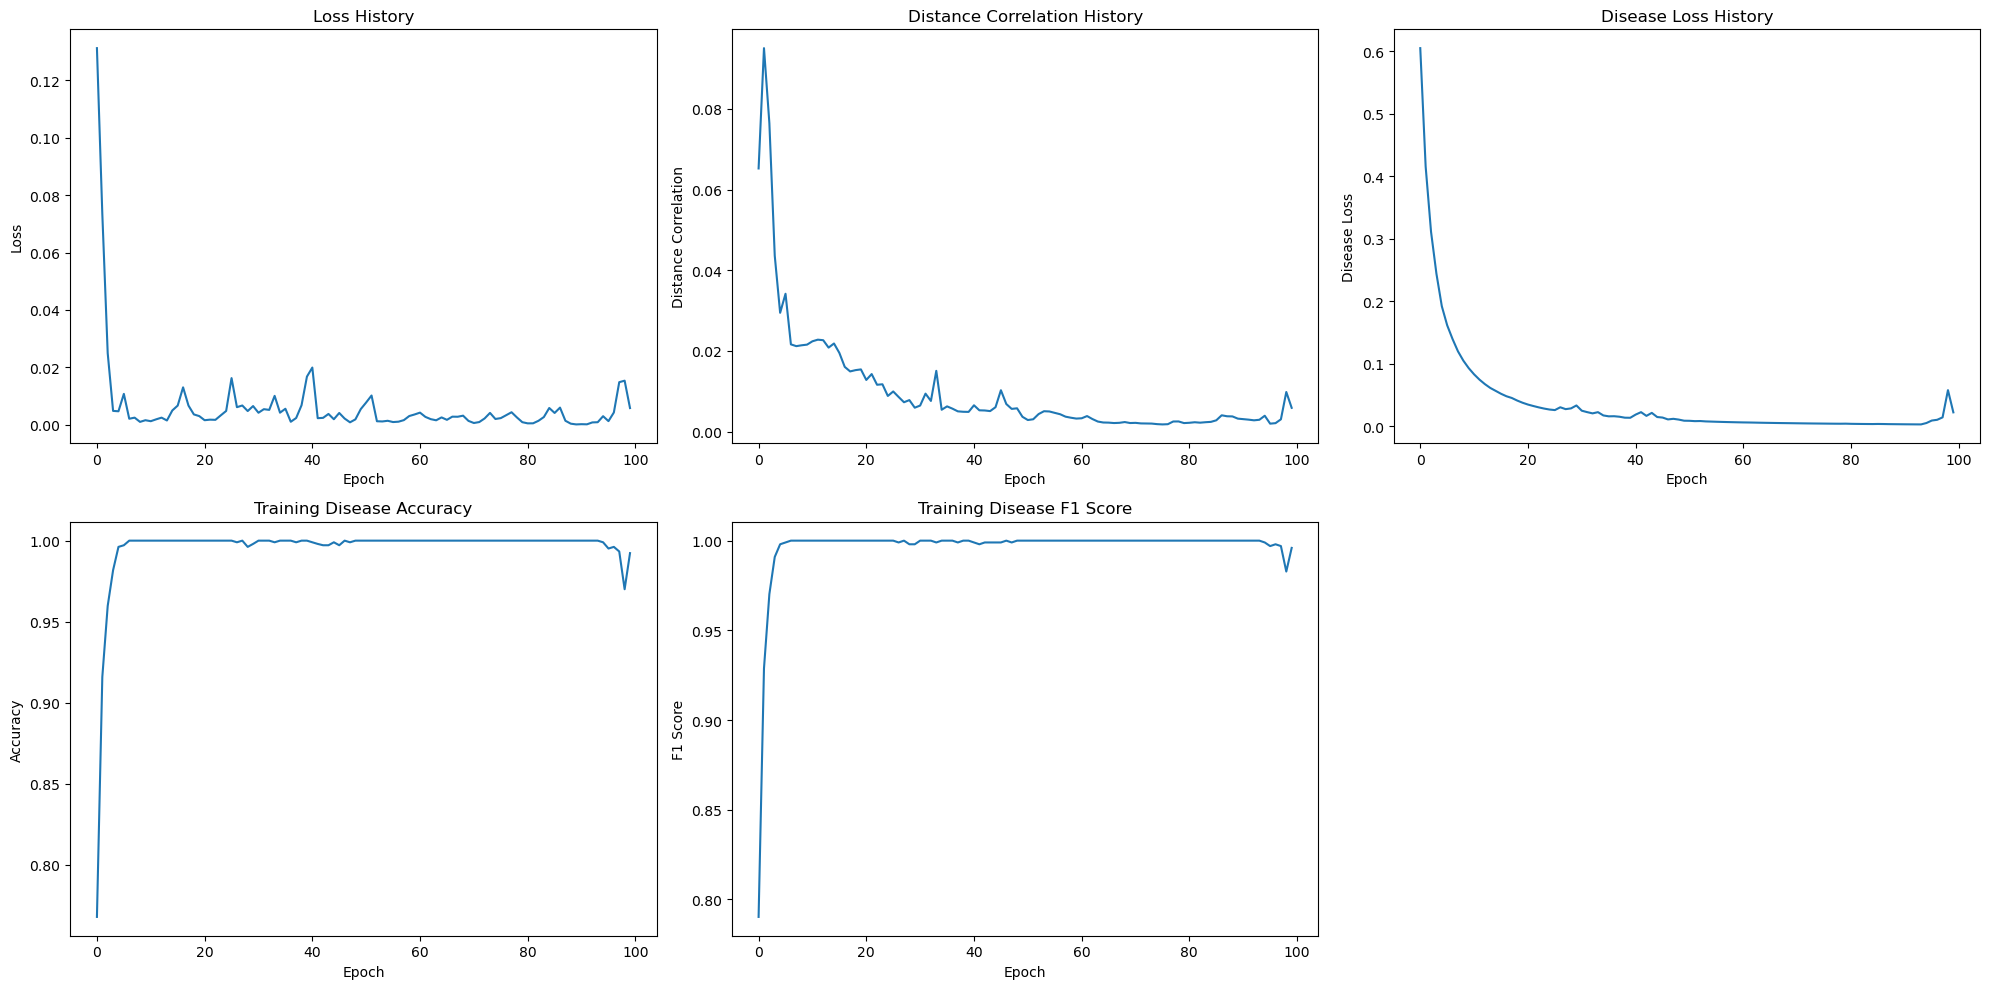

In [1]:
### data_all_loader has been added but not used yet
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_disease_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_all_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (predicted_disease_all > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss/len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_disease_data()
    x_all_train, y_all_train = generate_all_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion_disease_classifier = nn.BCELoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s = train_model(
    model, criterion, optimizer, data_loader, data_all_loader, num_epochs, 
    criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
)

# Plot the loss history, distance correlation history, disease loss history, training accuracy, and F1 score
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 3, 2)
plt.plot(dcor_history)
plt.title("Distance Correlation History")
plt.xlabel("Epoch")
plt.ylabel("Distance Correlation")

plt.subplot(2, 3, 3)
plt.plot(disease_loss_history)
plt.title("Disease Loss History")
plt.xlabel("Epoch")
plt.ylabel("Disease Loss")

plt.subplot(2, 3, 4)
plt.plot(train_disease_accs)
plt.title("Training Disease Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(2, 3, 5)
plt.plot(train_disease_f1s)
plt.title("Training Disease F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()



### with 20 percent validation and main model

Training values:
METFORMIN_C
1    291
0    104
Name: count, dtype: int64
Validation values:
METFORMIN_C
1    82
0    18
Name: count, dtype: int64
Training values:
PATGROUPFINAL_C
1    395
0    141
Name: count, dtype: int64
Validation values:
PATGROUPFINAL_C
1    100
0     35
Name: count, dtype: int64
Epoch [50/100], Loss: 0.0301, DCor: 0.0089
Validation Loss: 0.3018, Validation Acc: 0.8271, Validation F1: 0.9216, Val DCor: 0.0189
Epoch [100/100], Loss: 0.0049, DCor: 0.0041
Validation Loss: 0.3889, Validation Acc: 0.8500, Validation F1: 0.9137, Val DCor: 0.0238


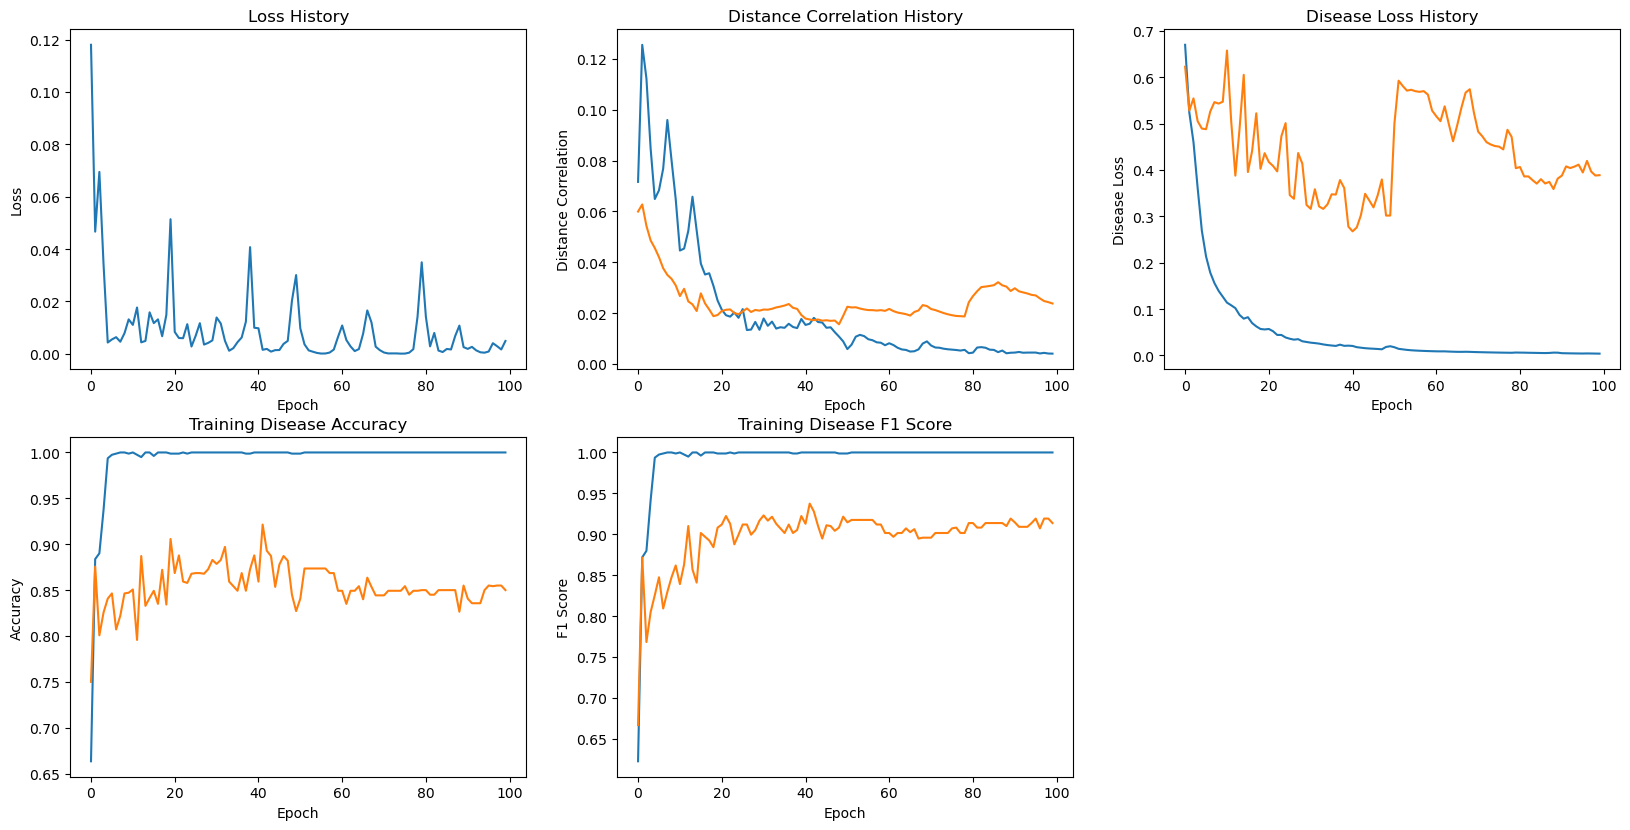

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        # layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_disease_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data(disease_group=0):
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    # Split the data into training and validation sets (80% train, 20% validation)
    
    train_data, val_data = train_test_split(
    merged_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=merged_data['PATGROUPFINAL_C']
    )

    metadata_columns = metadata.columns.tolist()
    feature_columns = [
        col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID'
    ]

    if disease_group:
        # Filter for disease group in both training and validation sets
        train_data = train_data[train_data['PATGROUPFINAL_C'] == 1]
        val_data = val_data[val_data['PATGROUPFINAL_C'] == 1]

        print("Training values:")
        print(train_data['METFORMIN_C'].value_counts())
        print("Validation values:")
        print(val_data['METFORMIN_C'].value_counts())

        # Prepare training data
        x_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_train = torch.tensor(train_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

        # Prepare validation data
        x_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_val = torch.tensor(val_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

        return x_train, y_train, x_val, y_val

    else:
        print("Training values:")
        print(train_data['PATGROUPFINAL_C'].value_counts())
        print("Validation values:")
        print(val_data['PATGROUPFINAL_C'].value_counts())

        # Prepare training data
        x_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_train = torch.tensor(train_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

        # Prepare validation data
        x_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_val = torch.tensor(val_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

        return x_train, y_train, x_val, y_val



# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, data_val_loader, data_all_val_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    # New lists for validation metrics
    val_loss_history = []
    val_accs = []
    val_f1s = []
    val_dcor_history = []  # New list to store validation distance correlation
    
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                predicted_drug=torch.sigmoid(predicted_drug)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & disease classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (torch.sigmoid(predicted_disease_all) > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute training metrics
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        # ----------------------------
        # Validation phase
        # ----------------------------
        model.eval()
        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_labels = []
        val_hidden_activations_list = []  # List to store validation hidden activations
        val_targets_list = []  # List to store validation targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_val_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease)> 0.5).float()
                epoch_val_preds.append(pred_tag.cpu())
                epoch_val_labels.append(y_batch.cpu())
                
            for x_batch, y_batch in data_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                val_hidden_activations_list.append(encoded_features.cpu())
                val_targets_list.append(y_batch.cpu())

        avg_val_loss = epoch_val_loss / len(data_all_val_loader)
        val_loss_history.append(avg_val_loss)

        epoch_val_preds = torch.cat(epoch_val_preds)
        epoch_val_labels = torch.cat(epoch_val_labels)

        val_acc = balanced_accuracy_score(epoch_val_labels, epoch_val_preds)
        val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        # Compute distance correlation for validation data
        val_hidden_activations_all = torch.cat(val_hidden_activations_list, dim=0)
        val_targets_all = torch.cat(val_targets_list, dim=0)
        val_hidden_activations_np = val_hidden_activations_all.numpy()
        val_targets_np = val_targets_all.numpy()
        val_dcor_value = dcor.distance_correlation_sqr(val_hidden_activations_np, val_targets_np)
        val_dcor_history.append(val_dcor_value)

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}, Val DCor: {val_dcor_value:.4f}')
    
    return (loss_history, dcor_history, disease_loss_history, train_disease_accs, 
            train_disease_f1s, val_loss_history, val_accs, val_f1s, val_dcor_history)


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train, x_val, y_val = generate_all_data(disease_group=1)
    x_all_train, y_all_train, x_all_val, y_all_val = generate_all_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
    # Create validation DataLoaders
    data_val_loader = create_stratified_dataloader(x_val, y_val, batch_size)
    data_all_val_loader = create_stratified_dataloader(x_all_val, y_all_val, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=0.002)
    criterion_classifier = nn.BCEWithLogitsLoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=0.002)
    criterion_disease_classifier = nn.BCEWithLogitsLoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
    (loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, 
     val_loss_history, val_accs, val_f1s, val_dcor_history) = train_model(
        model, criterion, optimizer, data_loader, data_all_loader, data_val_loader, data_all_val_loader, num_epochs, 
        criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
    )

    # Plot the loss history, distance correlation history, disease loss history, training and validation accuracy, and F1 score
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 3, 1)
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(3, 3, 2)
    plt.plot(dcor_history, label="train")
    plt.plot(val_dcor_history, label= "val")
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.subplot(3, 3, 3)
    plt.plot(disease_loss_history, label = "train")
    plt.plot(val_loss_history, label= "val")
    plt.title("Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")

    plt.subplot(3, 3, 4)
    plt.plot(train_disease_accs, label = "train")
    plt.plot(val_accs, label= "val")
    plt.title("Training Disease Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(3, 3, 5)
    plt.plot(train_disease_f1s, label = "train")
    plt.plot(val_f1s, label= "val")
    plt.title("Training Disease F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")



### With 20 percent validation and benchmark

Training values:
METFORMIN_C
1    291
0    104
Name: count, dtype: int64
Validation values:
METFORMIN_C
1    82
0    18
Name: count, dtype: int64
Training values:
PATGROUPFINAL_C
1    395
0    141
Name: count, dtype: int64
Validation values:
PATGROUPFINAL_C
1    100
0     35
Name: count, dtype: int64
Epoch [50/200], DCor: 0.1085
Validation Loss: 0.5876, Validation Acc: 0.8764, Validation F1: 0.8852, Val DCor: 0.0297
Epoch [100/200], DCor: 0.1083
Validation Loss: 0.6783, Validation Acc: 0.8814, Validation F1: 0.8913, Val DCor: 0.0294
Epoch [150/200], DCor: 0.1081
Validation Loss: 0.7387, Validation Acc: 0.8814, Validation F1: 0.8913, Val DCor: 0.0293
Epoch [200/200], DCor: 0.1081
Validation Loss: 0.7851, Validation Acc: 0.8814, Validation F1: 0.8913, Val DCor: 0.0293


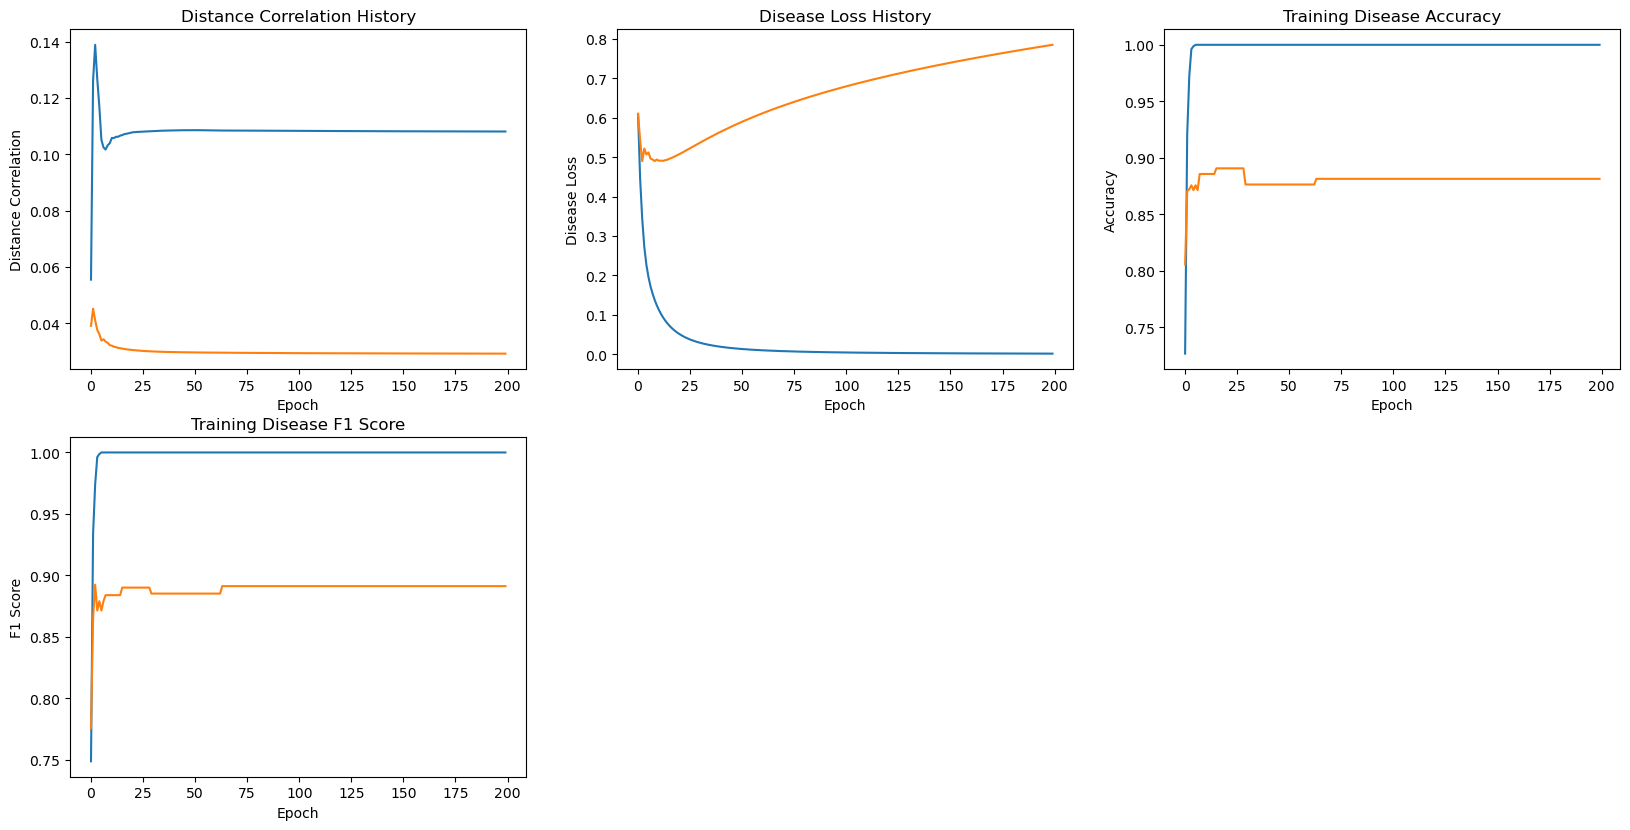

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        # layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def generate_all_data(disease_group=0):
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    # Split the data into training and validation sets (80% train, 20% validation)
    
    train_data, val_data = train_test_split(
    merged_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=merged_data['PATGROUPFINAL_C']
    )

    metadata_columns = metadata.columns.tolist()
    feature_columns = [
        col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID'
    ]

    if disease_group:
        # Filter for disease group in both training and validation sets
        train_data = train_data[train_data['PATGROUPFINAL_C'] == 1]
        val_data = val_data[val_data['PATGROUPFINAL_C'] == 1]

        print("Training values:")
        print(train_data['METFORMIN_C'].value_counts())
        print("Validation values:")
        print(val_data['METFORMIN_C'].value_counts())

        # Prepare training data
        x_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_train = torch.tensor(train_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

        # Prepare validation data
        x_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_val = torch.tensor(val_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

        return x_train, y_train, x_val, y_val

    else:
        print("Training values:")
        print(train_data['PATGROUPFINAL_C'].value_counts())
        print("Validation values:")
        print(val_data['PATGROUPFINAL_C'].value_counts())

        # Prepare training data
        x_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_train = torch.tensor(train_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

        # Prepare validation data
        x_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_val = torch.tensor(val_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

        return x_train, y_train, x_val, y_val



# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, data_loader, data_all_loader, data_val_loader, data_all_val_loader, num_epochs, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    # New lists for validation metrics
    val_loss_history = []
    val_accs = []
    val_f1s = []
    val_dcor_history = []  # New list to store validation distance correlation
    
    model = model.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
               
              
                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_batch
                # ----------------------------
                              
                encoded_features = model.encoder(x_batch)
               
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        

                # ----------------------------
                # Train encoder & disease classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (torch.sigmoid(predicted_disease_all) > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute training metrics
    
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        # ----------------------------
        # Validation phase
        # ----------------------------
        model.eval()
        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_labels = []
        val_hidden_activations_list = []  # List to store validation hidden activations
        val_targets_list = []  # List to store validation targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_val_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease)> 0.5).float()
                epoch_val_preds.append(pred_tag.cpu())
                epoch_val_labels.append(y_batch.cpu())
               
            for x_batch, y_batch in data_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                val_hidden_activations_list.append(encoded_features.cpu())
                val_targets_list.append(y_batch.cpu())

        avg_val_loss = epoch_val_loss / len(data_all_val_loader)
        val_loss_history.append(avg_val_loss)

        epoch_val_preds = torch.cat(epoch_val_preds)
        epoch_val_labels = torch.cat(epoch_val_labels)

        val_acc = balanced_accuracy_score(epoch_val_labels, epoch_val_preds)
        val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        # Compute distance correlation for validation data
        val_hidden_activations_all = torch.cat(val_hidden_activations_list, dim=0)
        val_targets_all = torch.cat(val_targets_list, dim=0)
        val_hidden_activations_np = val_hidden_activations_all.numpy()
        val_targets_np = val_targets_all.numpy()
        val_dcor_value = dcor.distance_correlation_sqr(val_hidden_activations_np, val_targets_np)
        val_dcor_history.append(val_dcor_value)

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], DCor: {dcor_value:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}, Val DCor: {val_dcor_value:.4f}')
    
    return (dcor_history, disease_loss_history, train_disease_accs, 
            train_disease_f1s, val_loss_history, val_accs, val_f1s, val_dcor_history)


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train, x_val, y_val = generate_all_data(disease_group=1)
    x_all_train, y_all_train, x_all_val, y_all_val = generate_all_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
    # Create validation DataLoaders
    data_val_loader = create_stratified_dataloader(x_val, y_val, batch_size)
    data_all_val_loader = create_stratified_dataloader(x_all_val, y_all_val, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion_disease_classifier = nn.BCEWithLogitsLoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
    (dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, 
     val_loss_history, val_accs, val_f1s, val_dcor_history) = train_model(
        model, data_loader, data_all_loader, data_val_loader, data_all_val_loader, num_epochs, 
        criterion_disease_classifier, optimizer_disease_classifier
    )

    # Plot the loss history, distance correlation history, disease loss history, training and validation accuracy, and F1 score
    plt.figure(figsize=(20, 15))


    plt.subplot(3, 3, 1)
    plt.plot(dcor_history, label="train")
    plt.plot(val_dcor_history, label= "val")
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.subplot(3, 3, 2)
    plt.plot(disease_loss_history, label = "train")
    plt.plot(val_loss_history, label= "val")
    plt.title("Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")

    plt.subplot(3, 3, 3)
    plt.plot(train_disease_accs, label = "train")
    plt.plot(val_accs, label= "val")
    plt.title("Training Disease Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(3, 3, 4)
    plt.plot(train_disease_f1s, label = "train")
    plt.plot(val_f1s, label= "val")
    plt.title("Training Disease F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")



### 5 fold cross validation and main model

Fold 1
Epoch [50/100], Loss: 0.0205, DCor: 0.0208
Validation Loss: 0.2874, Validation Acc: 0.8056, Validation F1: 0.8462, Val DCor: 0.1166
Test Loss: 0.3516, Test Acc: 0.7538, Test F1: 0.6667, Test DCor: 0.1100
Epoch [100/100], Loss: 0.0051, DCor: 0.0205
Validation Loss: 0.3084, Validation Acc: 0.8056, Validation F1: 0.8462, Val DCor: 0.1454
Test Loss: 0.4431, Test Acc: 0.7588, Test F1: 0.6757, Test DCor: 0.1424
Fold 2
Epoch [50/100], Loss: 0.0009, DCor: 0.0074
Validation Loss: 0.3111, Validation Acc: 0.8797, Validation F1: 0.8764, Val DCor: 0.0267
Test Loss: 0.2574, Test Acc: 0.7121, Test F1: 0.5970, Test DCor: 0.1656
Epoch [100/100], Loss: 0.0004, DCor: 0.0079
Validation Loss: 0.3879, Validation Acc: 0.8654, Validation F1: 0.8715, Val DCor: 0.0171
Test Loss: 0.3426, Test Acc: 0.7008, Test F1: 0.5758, Test DCor: 0.1714
Fold 3
Epoch [50/100], Loss: 0.0124, DCor: 0.0158
Validation Loss: 0.2243, Validation Acc: 0.8427, Validation F1: 0.8817, Val DCor: 0.0268
Test Loss: 0.3314, Test Acc: 

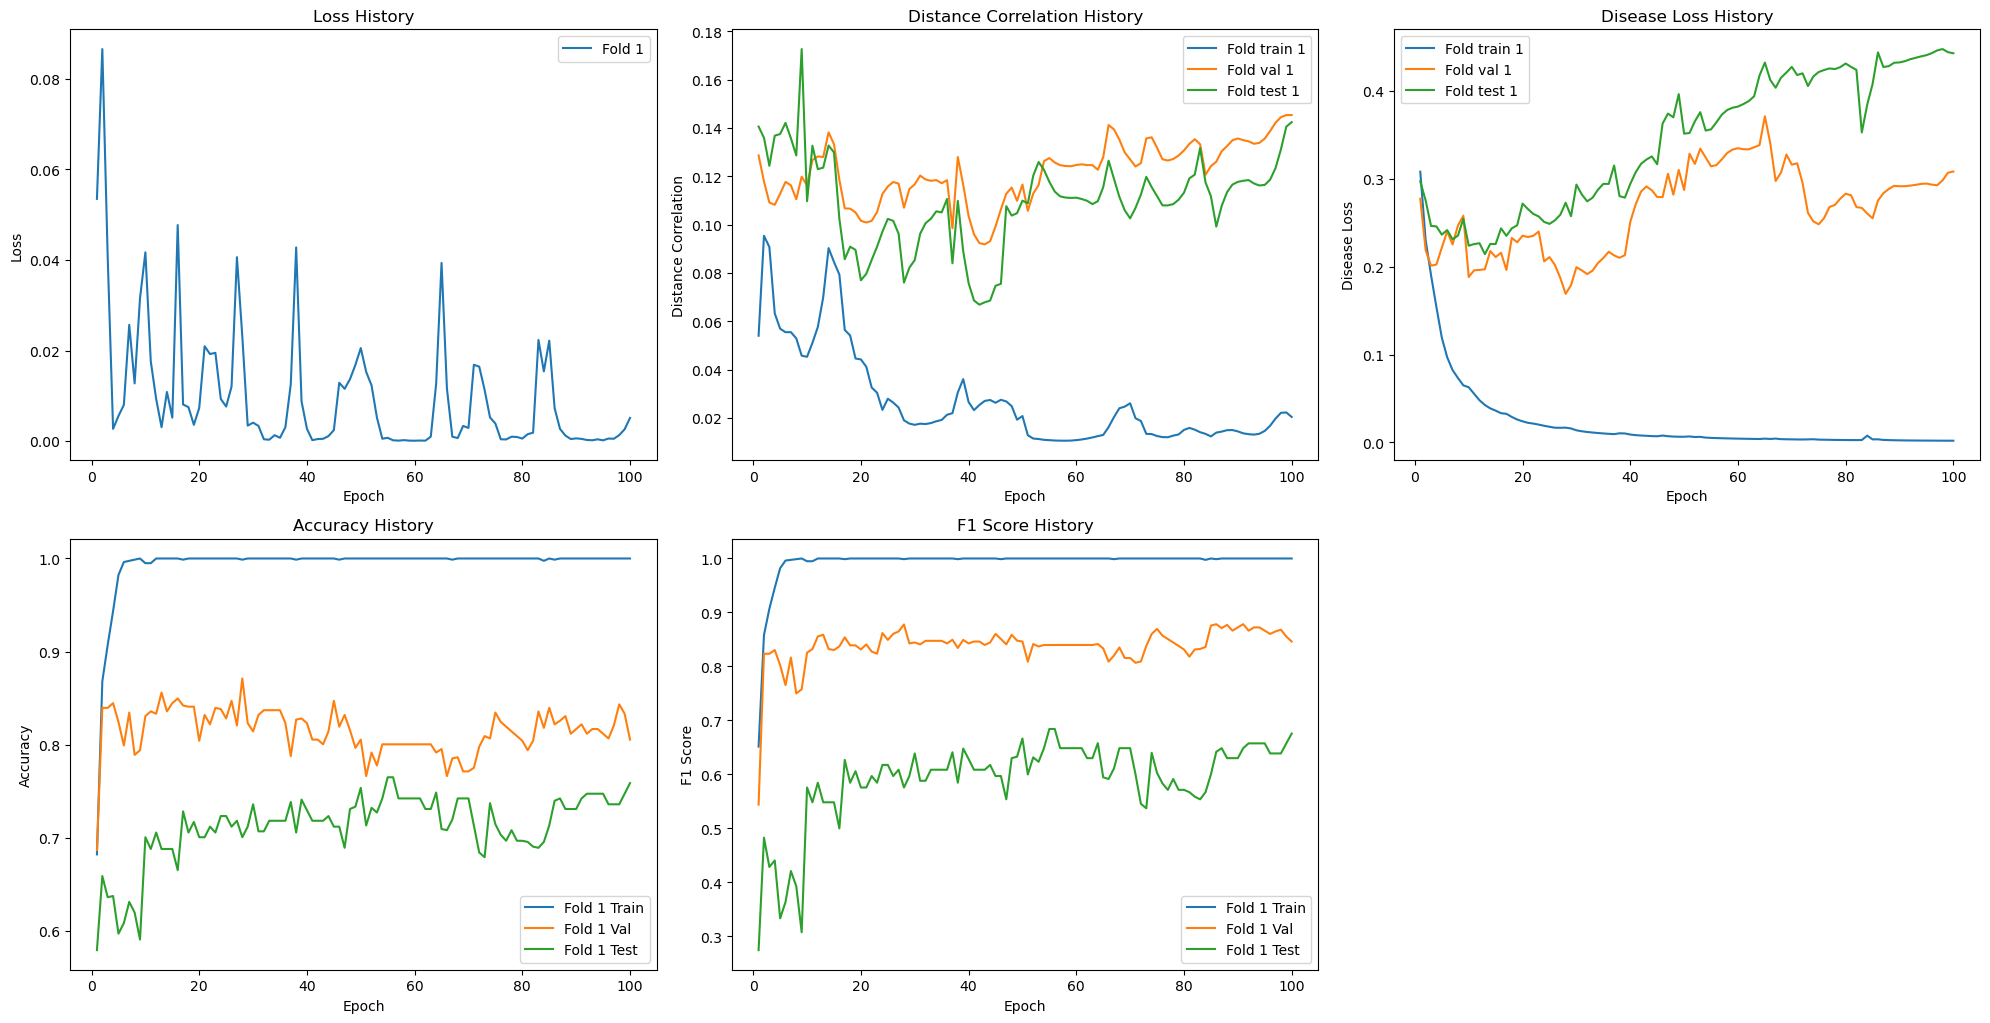

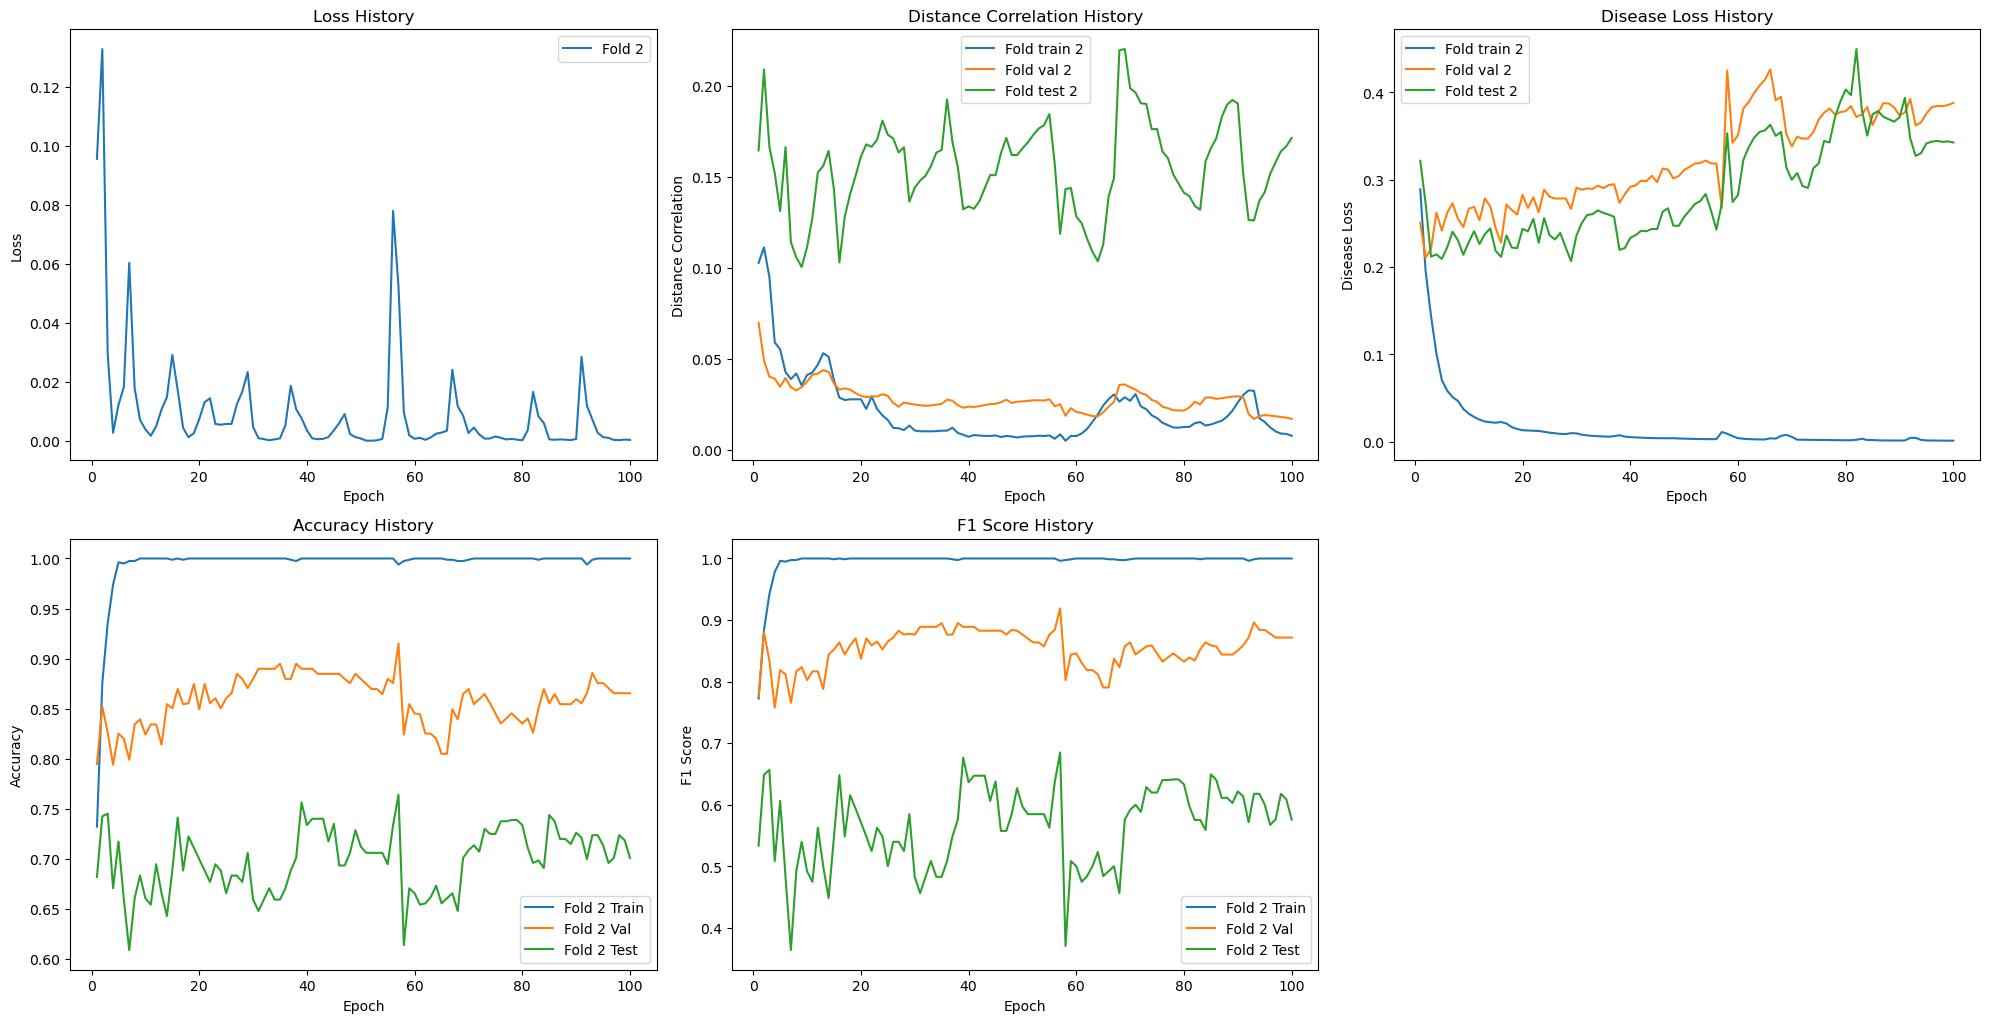

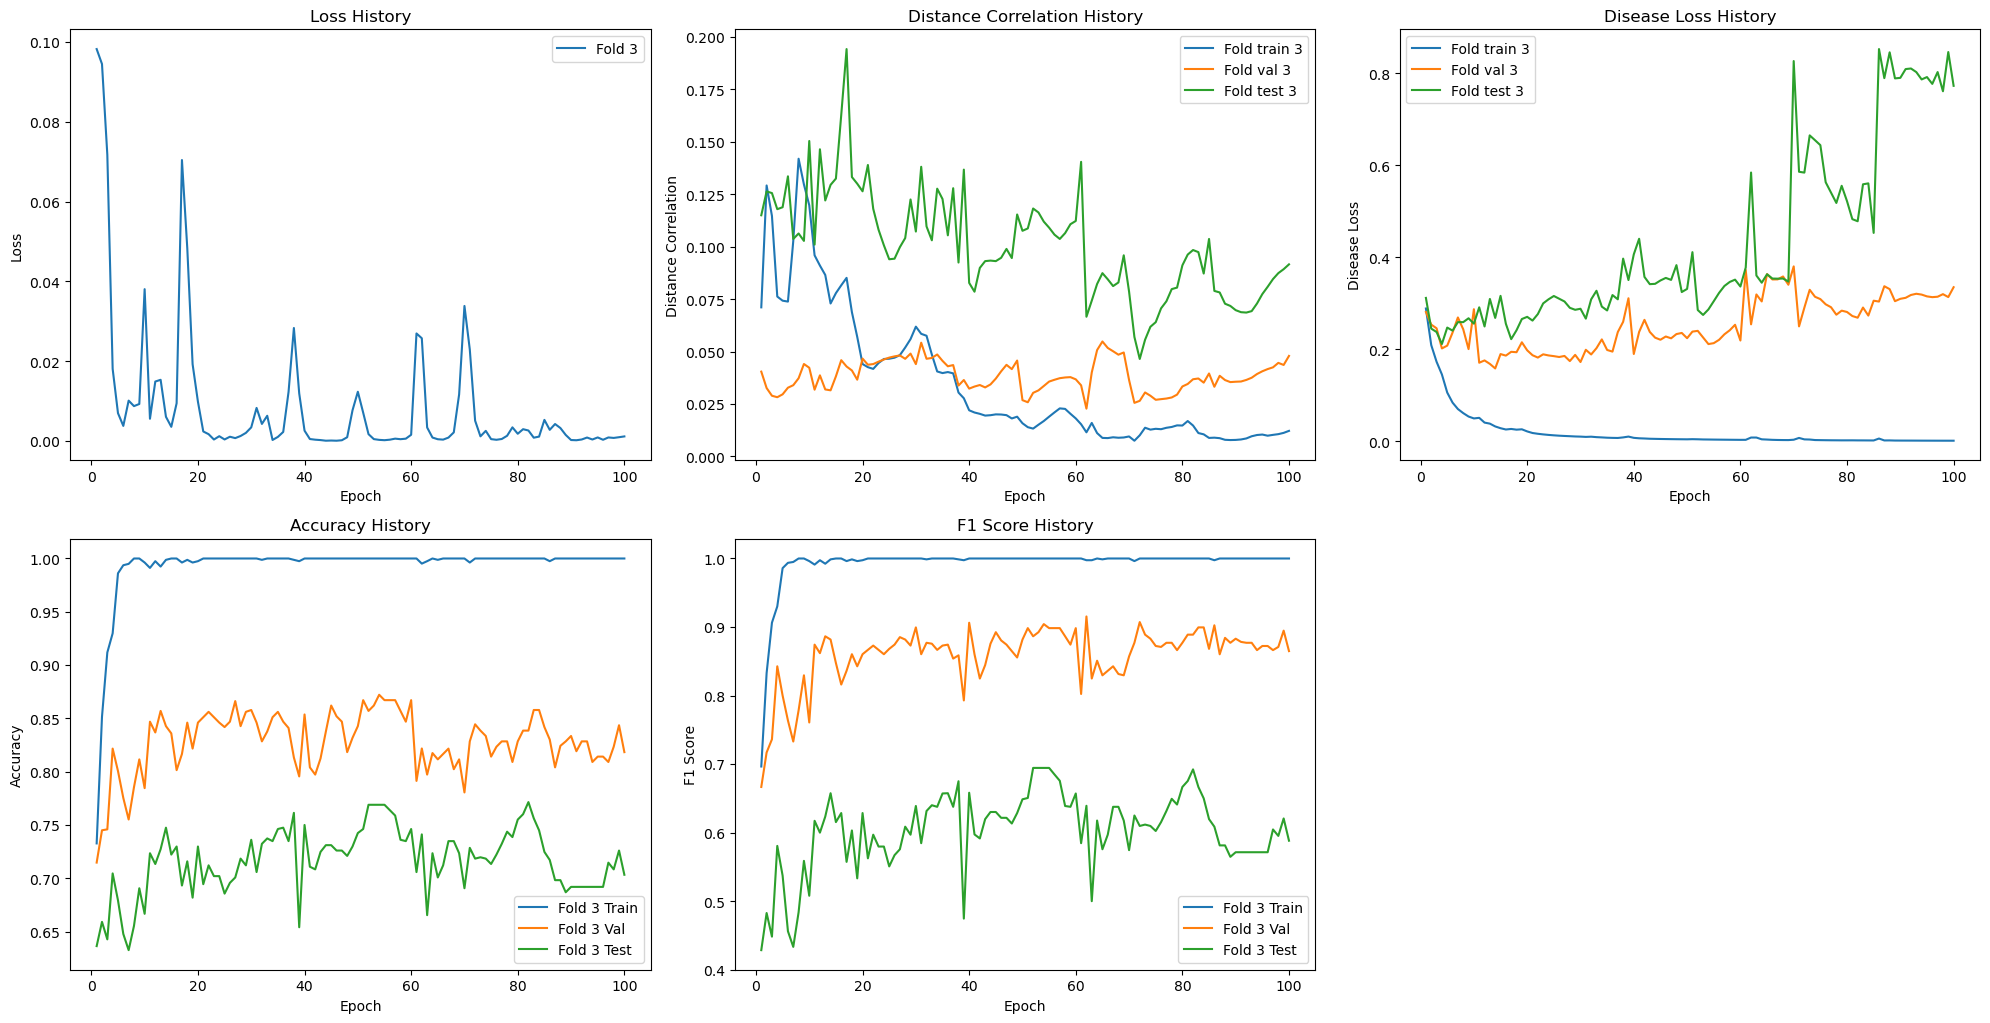

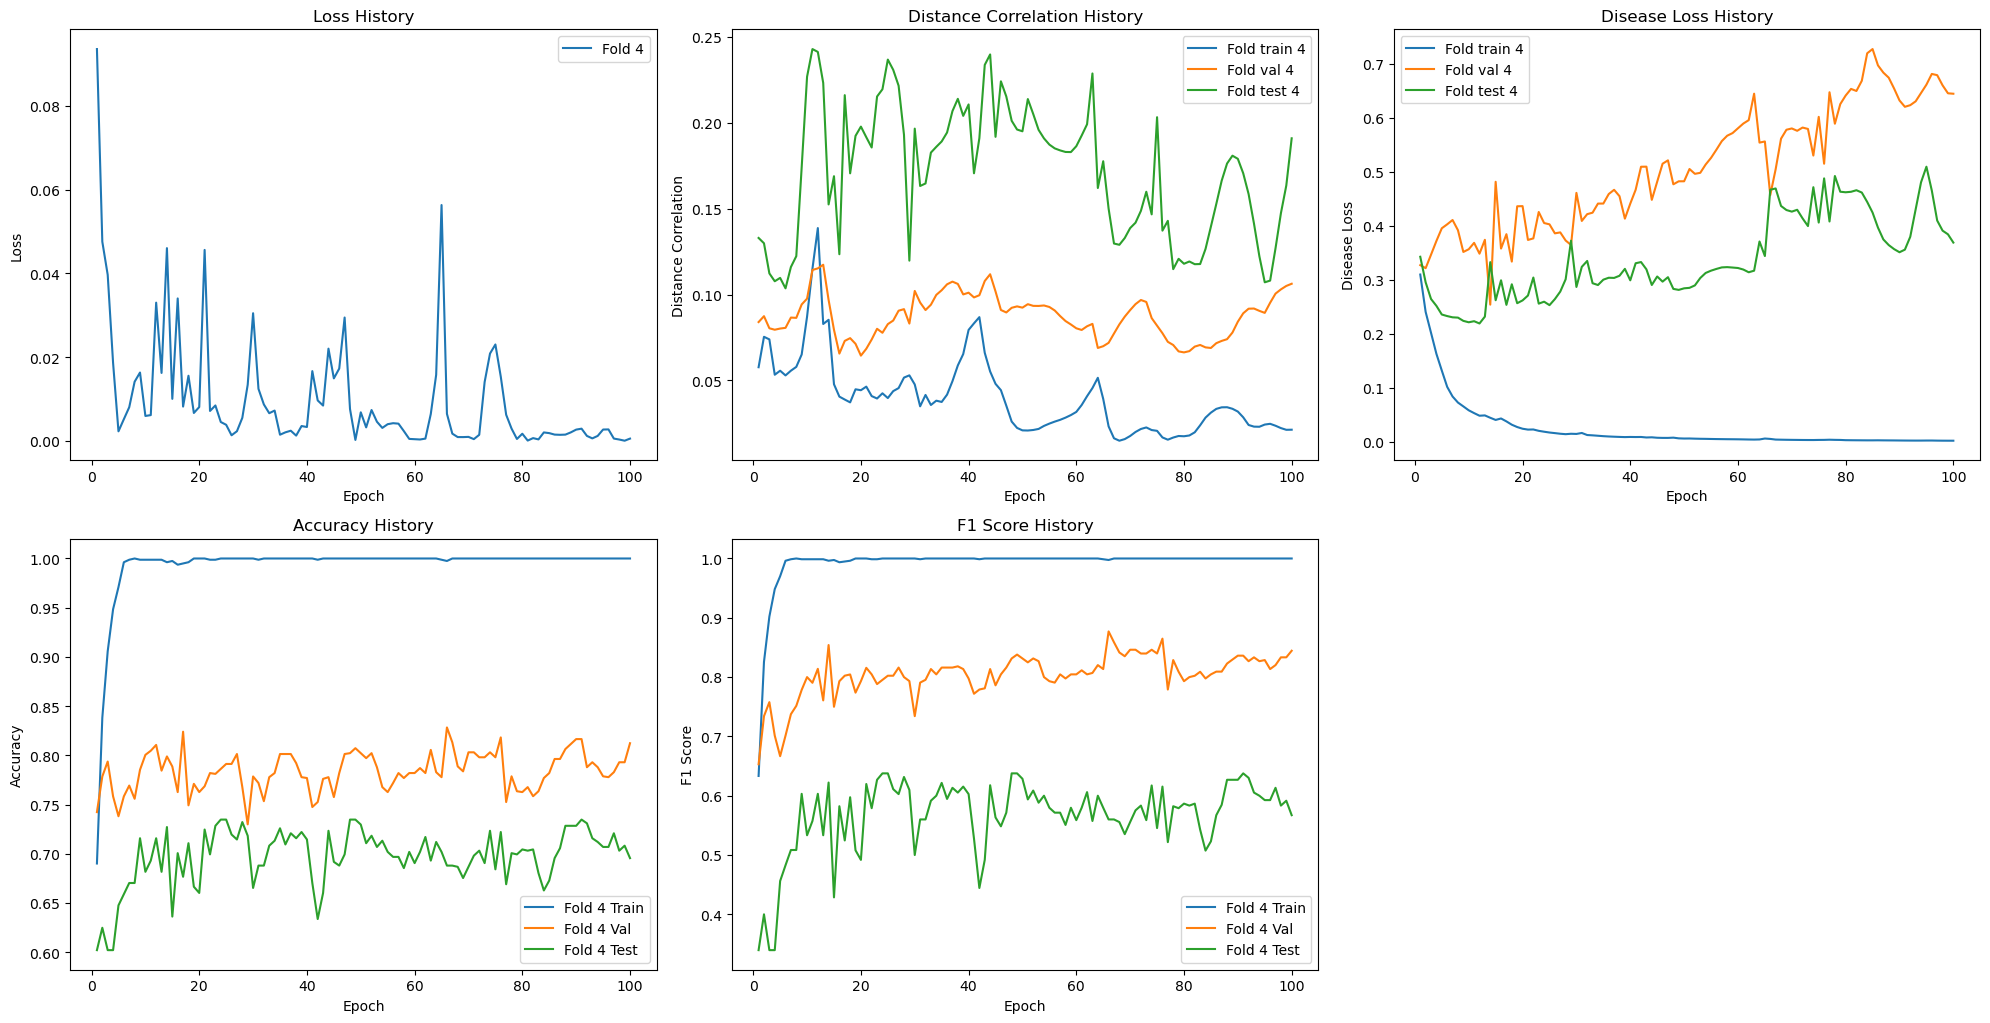

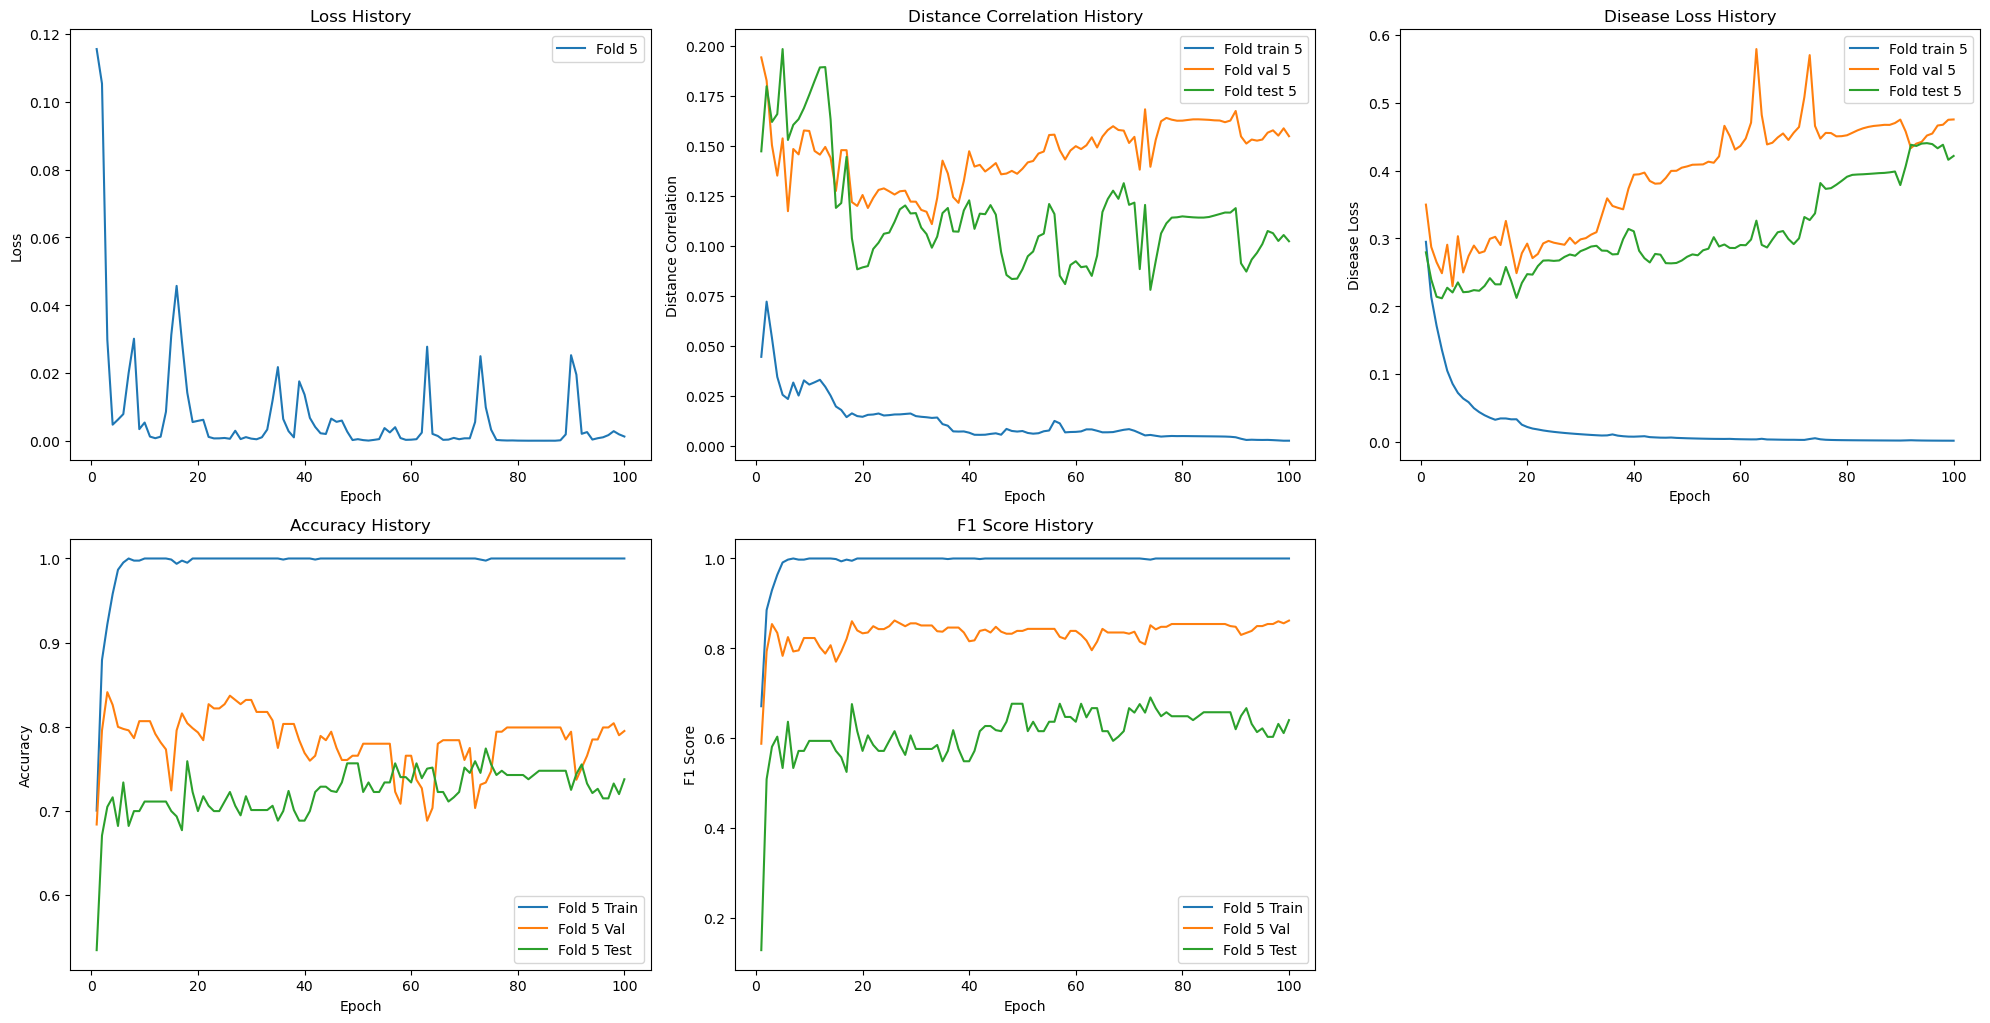

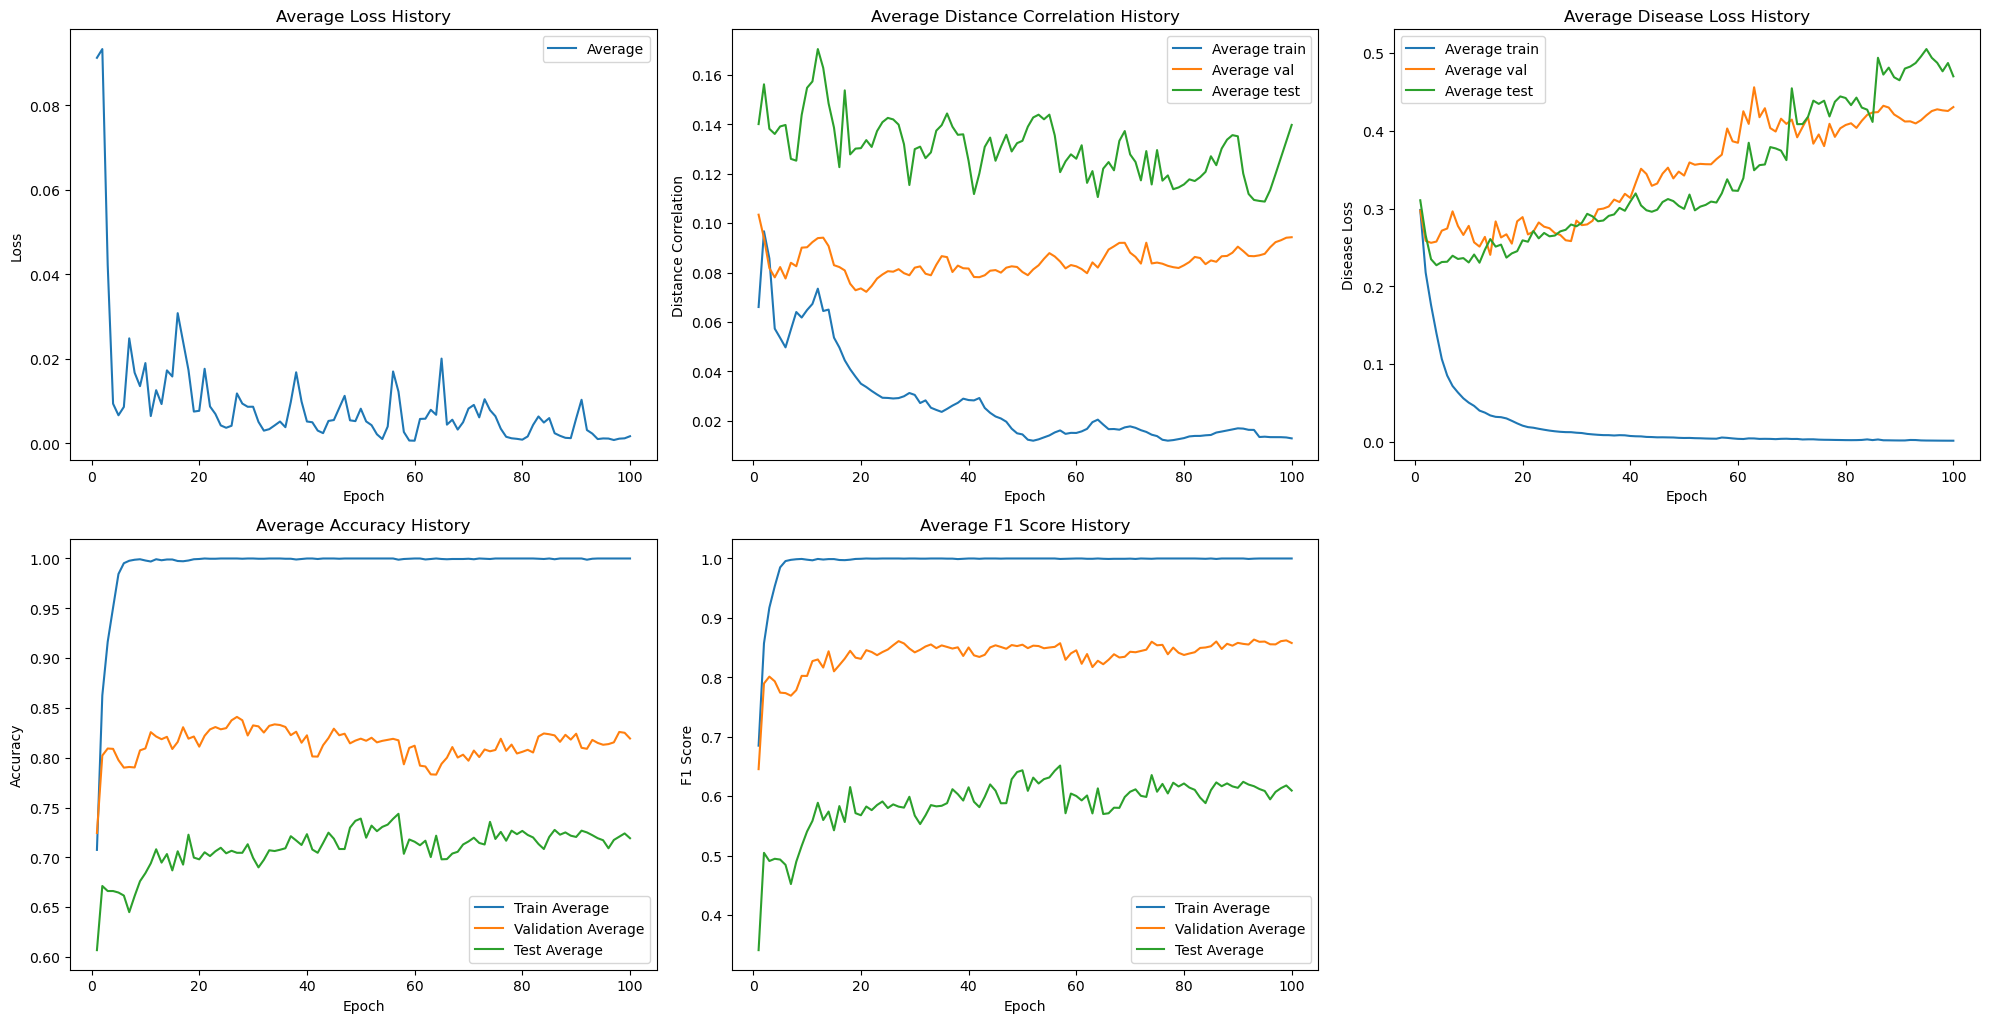

Average Test Accuracy over 5 folds: 0.7192


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def get_data():
    """
    Load and merge metadata and relative abundance data.
    """
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

def get_test_data():
    """
    Load and merge test metadata and relative abundance data.
    """
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, data_val_loader, data_all_val_loader, data_test_loader, data_all_test_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    # New lists for validation metrics
    val_loss_history = []
    val_accs = []
    val_f1s = []
    val_dcor_history = []  # New list to store validation distance correlation
    # New lists for test metrics
    test_loss_history = []
    test_accs = []
    test_f1s = []
    test_dcor_history = []
    
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                predicted_drug = torch.sigmoid(predicted_drug)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & disease classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (torch.sigmoid(predicted_disease_all) > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute training metrics
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        # ----------------------------
        # Validation phase
        # ----------------------------
        model.eval()
        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_labels = []
        val_hidden_activations_list = []  # List to store validation hidden activations
        val_targets_list = []  # List to store validation targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_val_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease) > 0.5).float()
                epoch_val_preds.append(pred_tag.cpu())
                epoch_val_labels.append(y_batch.cpu())
                
            for x_batch, y_batch in data_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                val_hidden_activations_list.append(encoded_features.cpu())
                val_targets_list.append(y_batch.cpu())

        avg_val_loss = epoch_val_loss / len(data_all_val_loader)
        val_loss_history.append(avg_val_loss)

        epoch_val_preds = torch.cat(epoch_val_preds)
        epoch_val_labels = torch.cat(epoch_val_labels)

        val_acc = balanced_accuracy_score(epoch_val_labels, epoch_val_preds)
        val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        # Compute distance correlation for validation data
        val_hidden_activations_all = torch.cat(val_hidden_activations_list, dim=0)
        val_targets_all = torch.cat(val_targets_list, dim=0)
        val_hidden_activations_np = val_hidden_activations_all.numpy()
        val_targets_np = val_targets_all.numpy()
        val_dcor_value = dcor.distance_correlation_sqr(val_hidden_activations_np, val_targets_np)
        val_dcor_history.append(val_dcor_value)
        
        # ----------------------------
        # Test phase
        # ----------------------------
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []
        test_hidden_activations_list = []  # List to store test hidden activations
        test_targets_list = []  # List to store test targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_test_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease) > 0.5).float()
                epoch_test_preds.append(pred_tag.cpu())
                epoch_test_labels.append(y_batch.cpu())
                
            for x_batch, y_batch in data_test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                test_hidden_activations_list.append(encoded_features.cpu())
                test_targets_list.append(y_batch.cpu())

        avg_test_loss = epoch_test_loss / len(data_all_test_loader)
        test_loss_history.append(avg_test_loss)

        epoch_test_preds = torch.cat(epoch_test_preds)
        epoch_test_labels = torch.cat(epoch_test_labels)

        test_acc = balanced_accuracy_score(epoch_test_labels, epoch_test_preds)
        test_f1 = f1_score(epoch_test_labels, epoch_test_preds)

        test_accs.append(test_acc)
        test_f1s.append(test_f1)
        
        # Compute distance correlation for test data
        test_hidden_activations_all = torch.cat(test_hidden_activations_list, dim=0)
        test_targets_all = torch.cat(test_targets_list, dim=0)
        test_hidden_activations_np = test_hidden_activations_all.numpy()
        test_targets_np = test_targets_all.numpy()
        test_dcor_value = dcor.distance_correlation_sqr(test_hidden_activations_np, test_targets_np)
        test_dcor_history.append(test_dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}, Val DCor: {val_dcor_value:.4f}')
            print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test DCor: {test_dcor_value:.4f}')
    
    return (loss_history, dcor_history, disease_loss_history, train_disease_accs, 
            train_disease_f1s, val_loss_history, val_accs, val_f1s, val_dcor_history,
            test_loss_history, test_accs, test_f1s, test_dcor_history)

# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 64

    # Load merged data
    merged_data_all = get_data()
    merged_test_data_all = get_test_data()

    # Define feature columns
    metadata_columns = pd.read_csv('MetaCardis_data/train_T2D_metadata.csv').columns.tolist()
    feature_columns = [
        col for col in merged_data_all.columns if col not in metadata_columns and col != 'SampleID'
    ]

    X = merged_data_all[feature_columns].values
    y_all = merged_data_all['PATGROUPFINAL_C'].values  # Labels for disease classification

    # Prepare test data
    x_test_all = torch.tensor(merged_test_data_all[feature_columns].values, dtype=torch.float32)
    y_test_all = torch.tensor(merged_test_data_all['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
    
    # Disease group data (patients with PATGROUPFINAL_C == 1) in test set
    test_data_disease = merged_test_data_all[merged_test_data_all['PATGROUPFINAL_C'] == 1]
    x_test_disease = torch.tensor(test_data_disease[feature_columns].values, dtype=torch.float32)
    y_test_disease = torch.tensor(test_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    # Initialize StratifiedKFold
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # To store metrics across folds
    metrics_per_fold = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y_all)):
        print(f"Fold {fold+1}")

        # Split data into training and validation sets
        train_data = merged_data_all.iloc[train_index]
        val_data = merged_data_all.iloc[val_index]

        # Prepare training data
        x_all_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_all_train = torch.tensor(train_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
        
        x_all_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_all_val = torch.tensor(val_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
        
        # Disease group data (patients with PATGROUPFINAL_C == 1)
        train_data_disease = train_data[train_data['PATGROUPFINAL_C'] == 1]
        val_data_disease = val_data[val_data['PATGROUPFINAL_C'] == 1]
        
        x_disease_train = torch.tensor(train_data_disease[feature_columns].values, dtype=torch.float32)
        y_disease_train = torch.tensor(train_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
        
        x_disease_val = torch.tensor(val_data_disease[feature_columns].values, dtype=torch.float32)
        y_disease_val = torch.tensor(val_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
        
        # Create stratified DataLoaders
        data_loader = create_stratified_dataloader(x_disease_train, y_disease_train, batch_size)
        data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
        data_val_loader = create_stratified_dataloader(x_disease_val, y_disease_val, batch_size)
        data_all_val_loader = create_stratified_dataloader(x_all_val, y_all_val, batch_size)
        data_test_loader = create_stratified_dataloader(x_test_disease, y_test_disease, batch_size)
        data_all_test_loader = create_stratified_dataloader(x_test_all, y_test_all, batch_size)
        
        # Compute positive class weight for disease classification
        num_pos_disease = y_all_train.sum().item()
        num_neg_disease = len(y_all_train) - num_pos_disease
        pos_weight_value_disease = num_neg_disease / num_pos_disease
        pos_weight_disease = torch.tensor([pos_weight_value_disease], dtype=torch.float32).to(device)

        # Compute positive class weight for drug classification
        num_pos_drug = y_disease_train.sum().item()
        num_neg_drug = len(y_disease_train) - num_pos_drug
        pos_weight_value_drug = num_neg_drug / num_pos_drug
        pos_weight_drug = torch.tensor([pos_weight_value_drug], dtype=torch.float32).to(device)


        # Define model, loss, and optimizer
        model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
        criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
        optimizer = optim.Adam(model.encoder.parameters(), lr=0.002)
        criterion_classifier = nn.BCEWithLogitsLoss(pos_weight=pos_weight_drug).to(device)  # Use binary cross-entropy loss for classification
        optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=0.002)
        criterion_disease_classifier = nn.BCEWithLogitsLoss(pos_weight=pos_weight_disease).to(device)
        optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

        # Move model and criteria to device
        model = model.to(device)
        criterion = criterion.to(device)
        criterion_classifier = criterion_classifier.to(device)
        criterion_disease_classifier = criterion_disease_classifier.to(device)

        # Train the model
        (loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, 
         val_loss_history, val_accs, val_f1s, val_dcor_history,
         test_loss_history, test_accs, test_f1s, test_dcor_history) = train_model(
            model, criterion, optimizer, data_loader, data_all_loader, data_val_loader, data_all_val_loader, data_test_loader, data_all_test_loader, num_epochs, 
            criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
        )

        # Store metrics for this fold
        metrics_per_fold.append({
            'loss_history': loss_history,
            'dcor_history': dcor_history,
            'disease_loss_history': disease_loss_history,
            'train_disease_accs': train_disease_accs,
            'train_disease_f1s': train_disease_f1s,
            'val_loss_history': val_loss_history,
            'val_accs': val_accs,
            'val_f1s': val_f1s,
            'val_dcor_history': val_dcor_history,
            'test_loss_history': test_loss_history,
            'test_accs': test_accs,
            'test_f1s': test_f1s,
            'test_dcor_history': test_dcor_history
        })

    num_epochs = len(metrics_per_fold[0]['loss_history'])
    epochs = range(1, num_epochs + 1)

    # Initialize dictionaries to collect metrics across folds
    avg_metrics = {
        'loss_history': np.zeros(num_epochs),
        'dcor_history': np.zeros(num_epochs),
        'disease_loss_history': np.zeros(num_epochs),
        'train_disease_accs': np.zeros(num_epochs),
        'train_disease_f1s': np.zeros(num_epochs),
        'val_loss_history': np.zeros(num_epochs),
        'val_accs': np.zeros(num_epochs),
        'val_f1s': np.zeros(num_epochs),
        'val_dcor_history': np.zeros(num_epochs),
        'test_loss_history': np.zeros(num_epochs),
        'test_accs': np.zeros(num_epochs),
        'test_f1s': np.zeros(num_epochs),
        'test_dcor_history': np.zeros(num_epochs)
    }

    # Plot metrics per fold and accumulate for averaging
    for fold_idx, fold_metrics in enumerate(metrics_per_fold):
        # Accumulate metrics for averaging
        for key in avg_metrics.keys():
            avg_metrics[key] += np.array(fold_metrics[key])
        
        # Plot metrics for this fold
        plt.figure(figsize=(20, 15))
        
        plt.subplot(3, 3, 1)
        plt.plot(epochs, fold_metrics['loss_history'], label=f'Fold {fold_idx+1}')
        plt.title("Loss History")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        
        plt.subplot(3, 3, 2)
        plt.plot(epochs, fold_metrics['dcor_history'], label=f'Fold train {fold_idx+1}')
        plt.plot(epochs, fold_metrics['val_dcor_history'], label=f'Fold val {fold_idx+1}')
        plt.plot(epochs, fold_metrics['test_dcor_history'], label=f'Fold test {fold_idx+1}')
        plt.title("Distance Correlation History")
        plt.xlabel("Epoch")
        plt.ylabel("Distance Correlation")
        plt.legend()
        
        plt.subplot(3, 3, 3)
        plt.plot(epochs, fold_metrics['disease_loss_history'], label=f'Fold train {fold_idx+1}')
        plt.plot(epochs, fold_metrics['val_loss_history'], label=f'Fold val {fold_idx+1}')
        plt.plot(epochs, fold_metrics['test_loss_history'], label=f'Fold test {fold_idx+1}')
        plt.title("Disease Loss History")
        plt.xlabel("Epoch")
        plt.ylabel("Disease Loss")
        plt.legend()
        
        plt.subplot(3, 3, 4)
        plt.plot(epochs, fold_metrics['train_disease_accs'], label=f'Fold {fold_idx+1} Train')
        plt.plot(epochs, fold_metrics['val_accs'], label=f'Fold {fold_idx+1} Val')
        plt.plot(epochs, fold_metrics['test_accs'], label=f'Fold {fold_idx+1} Test')
        plt.title("Accuracy History")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.subplot(3, 3, 5)
        plt.plot(epochs, fold_metrics['train_disease_f1s'], label=f'Fold {fold_idx+1} Train')
        plt.plot(epochs, fold_metrics['val_f1s'], label=f'Fold {fold_idx+1} Val')
        plt.plot(epochs, fold_metrics['test_f1s'], label=f'Fold {fold_idx+1} Test')
        plt.title("F1 Score History")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    # Compute averages across folds
    for key in avg_metrics.keys():
        avg_metrics[key] /= len(metrics_per_fold)

    # Plot average metrics across folds
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 3, 1)
    plt.plot(epochs, avg_metrics['loss_history'], label='Average')
    plt.title("Average Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(3, 3, 2)
    plt.plot(epochs, avg_metrics['dcor_history'], label='Average train')
    plt.plot(epochs, avg_metrics['val_dcor_history'], label='Average val')
    plt.plot(epochs, avg_metrics['test_dcor_history'], label='Average test')
    plt.title("Average Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")
    plt.legend()

    plt.subplot(3, 3, 3)
    plt.plot(epochs, avg_metrics['disease_loss_history'], label='Average train')
    plt.plot(epochs, avg_metrics['val_loss_history'], label='Average val')
    plt.plot(epochs, avg_metrics['test_loss_history'], label='Average test')
    plt.title("Average Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")
    plt.legend()

    plt.subplot(3, 3, 4)
    plt.plot(epochs, avg_metrics['train_disease_accs'], label='Train Average')
    plt.plot(epochs, avg_metrics['val_accs'], label='Validation Average')
    plt.plot(epochs, avg_metrics['test_accs'], label='Test Average')
    plt.title("Average Accuracy History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 3, 5)
    plt.plot(epochs, avg_metrics['train_disease_f1s'], label='Train Average')
    plt.plot(epochs, avg_metrics['val_f1s'], label='Validation Average')
    plt.plot(epochs, avg_metrics['test_f1s'], label='Test Average')
    plt.title("Average F1 Score History")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print average of the final epoch's test accuracy across folds
    avg_test_accs = avg_metrics['test_accs'][-1]
    print(f"Average Test Accuracy over {n_splits} folds: {avg_test_accs:.4f}")


### 5 fold corss validation bench mark on train, val and test

Fold 1


Epoch [50/100], DCor: 0.0612
Validation Loss: 0.3118, Validation Acc: 0.8081, Validation F1: 0.8229, Val DCor: 0.1505
Test Loss: 0.3214, Test Acc: 0.7311, Test F1: 0.6301, Test DCor: 0.1625
Epoch [100/100], DCor: 0.0615
Validation Loss: 0.3627, Validation Acc: 0.8131, Validation F1: 0.8295, Val DCor: 0.1513
Test Loss: 0.3922, Test Acc: 0.7652, Test F1: 0.6842, Test DCor: 0.1639
Fold 2
Epoch [50/100], DCor: 0.0642
Validation Loss: 0.4392, Validation Acc: 0.8401, Validation F1: 0.8391, Val DCor: 0.0442
Test Loss: 0.3030, Test Acc: 0.6894, Test F1: 0.5538, Test DCor: 0.2049
Epoch [100/100], DCor: 0.0640
Validation Loss: 0.5317, Validation Acc: 0.8452, Validation F1: 0.8457, Val DCor: 0.0434
Test Loss: 0.3559, Test Acc: 0.7008, Test F1: 0.5758, Test DCor: 0.2057
Fold 3
Epoch [50/100], DCor: 0.0925
Validation Loss: 0.1725, Validation Acc: 0.8519, Validation F1: 0.8804, Val DCor: 0.0602
Test Loss: 0.2759, Test Acc: 0.7424, Test F1: 0.6486, Test DCor: 0.1582
Epoch [100/100], DCor: 0.0923
Vali

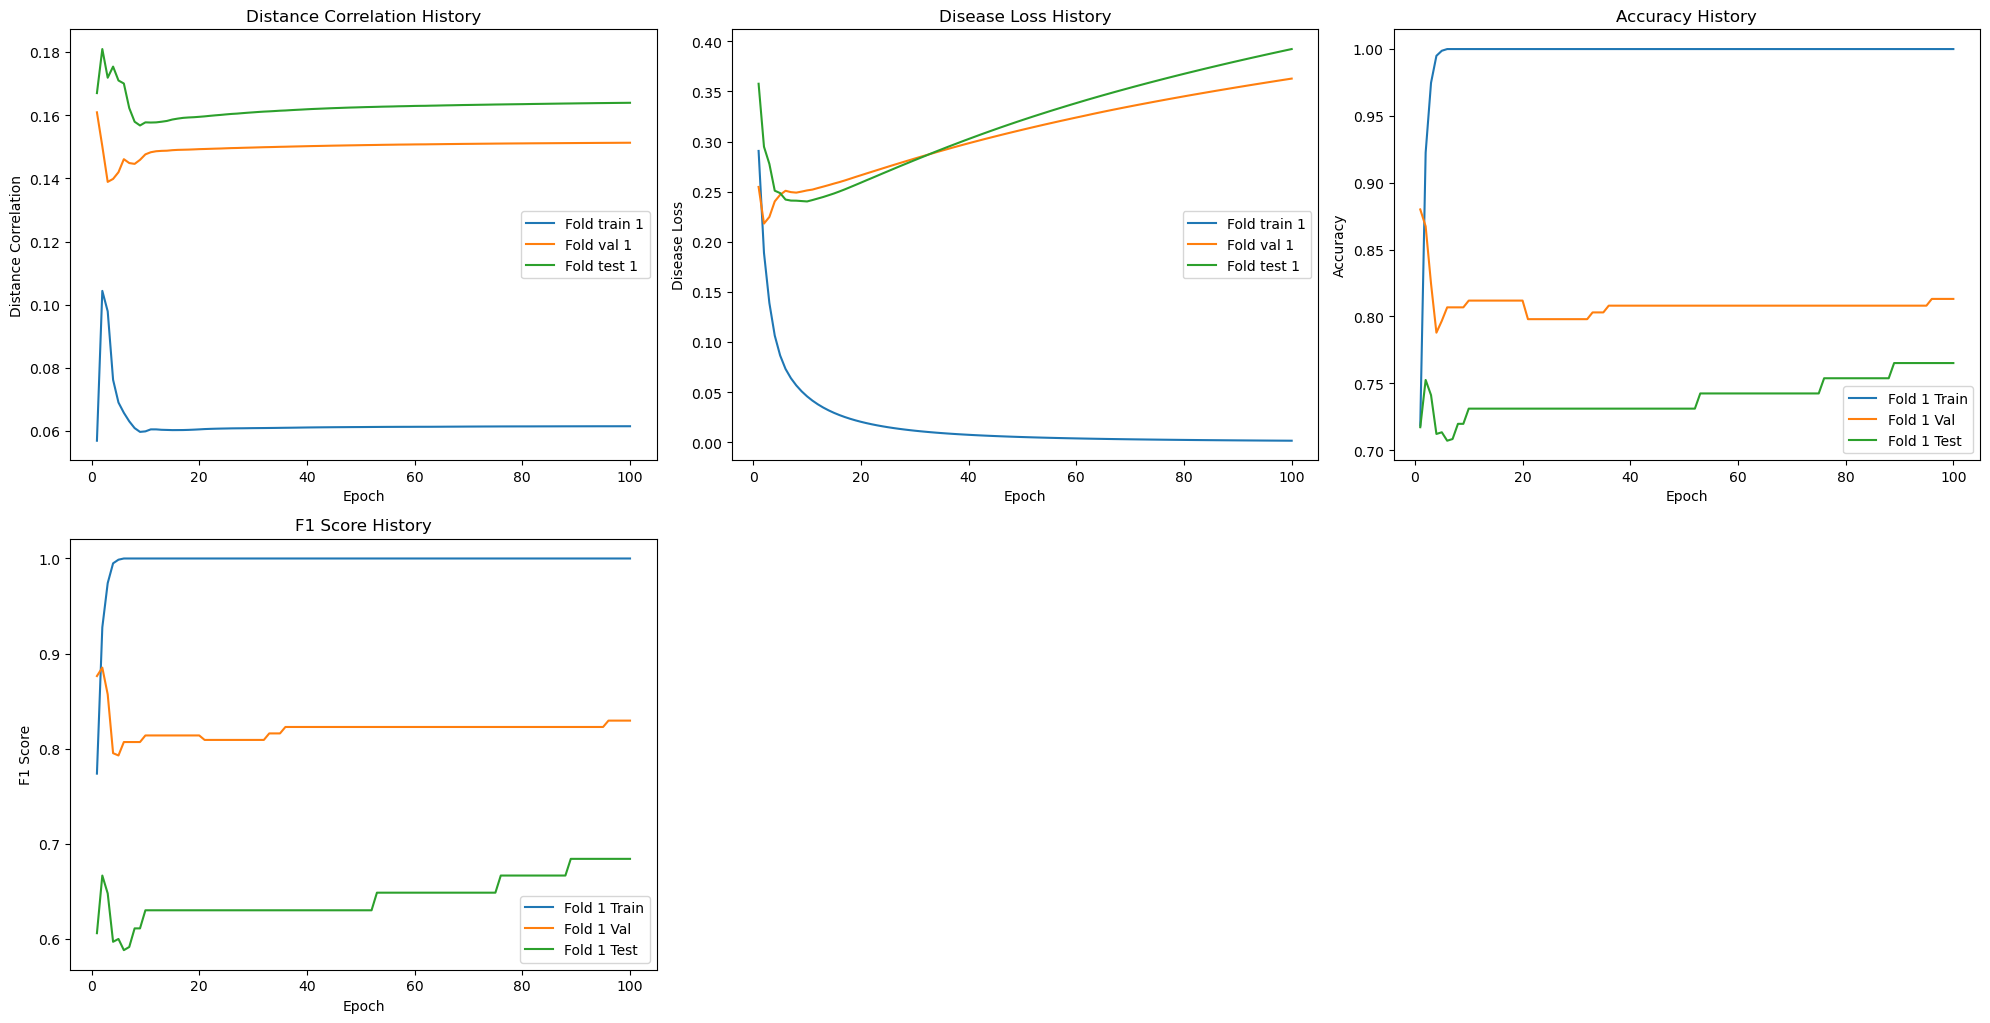

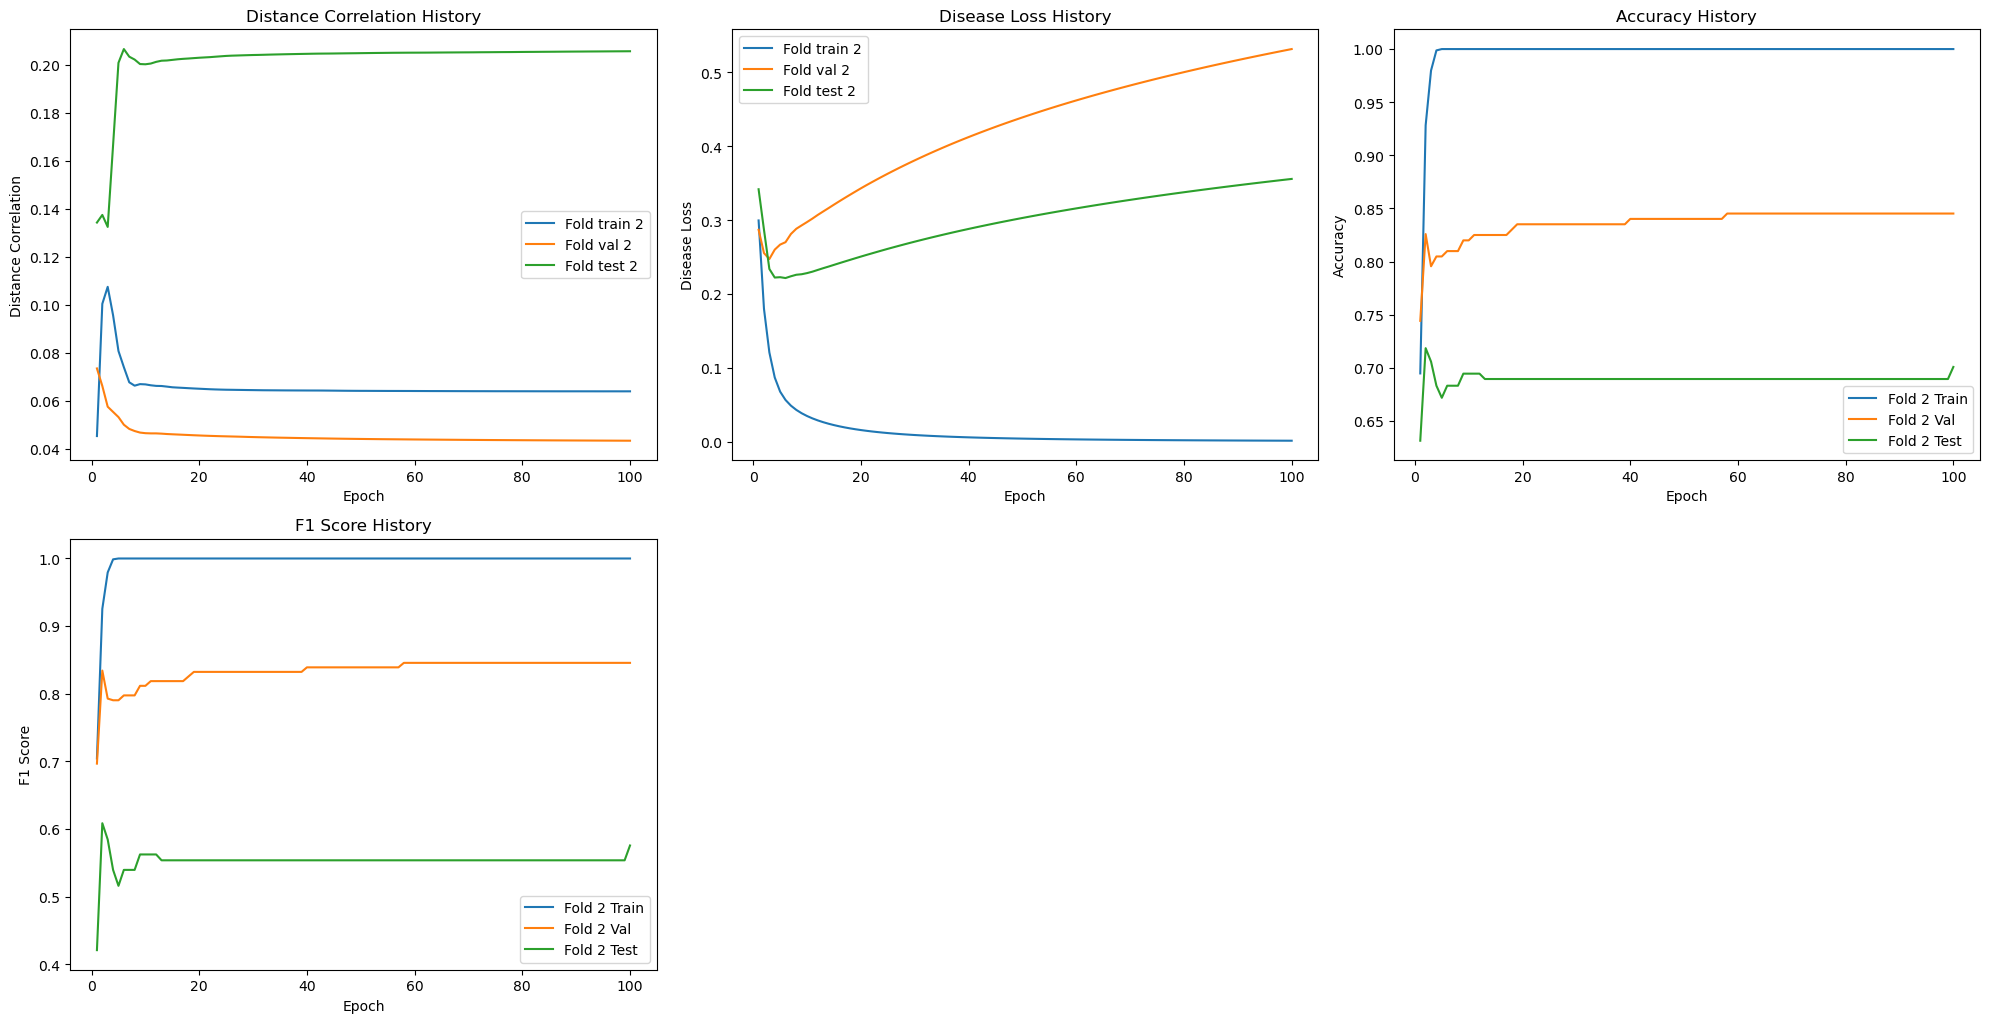

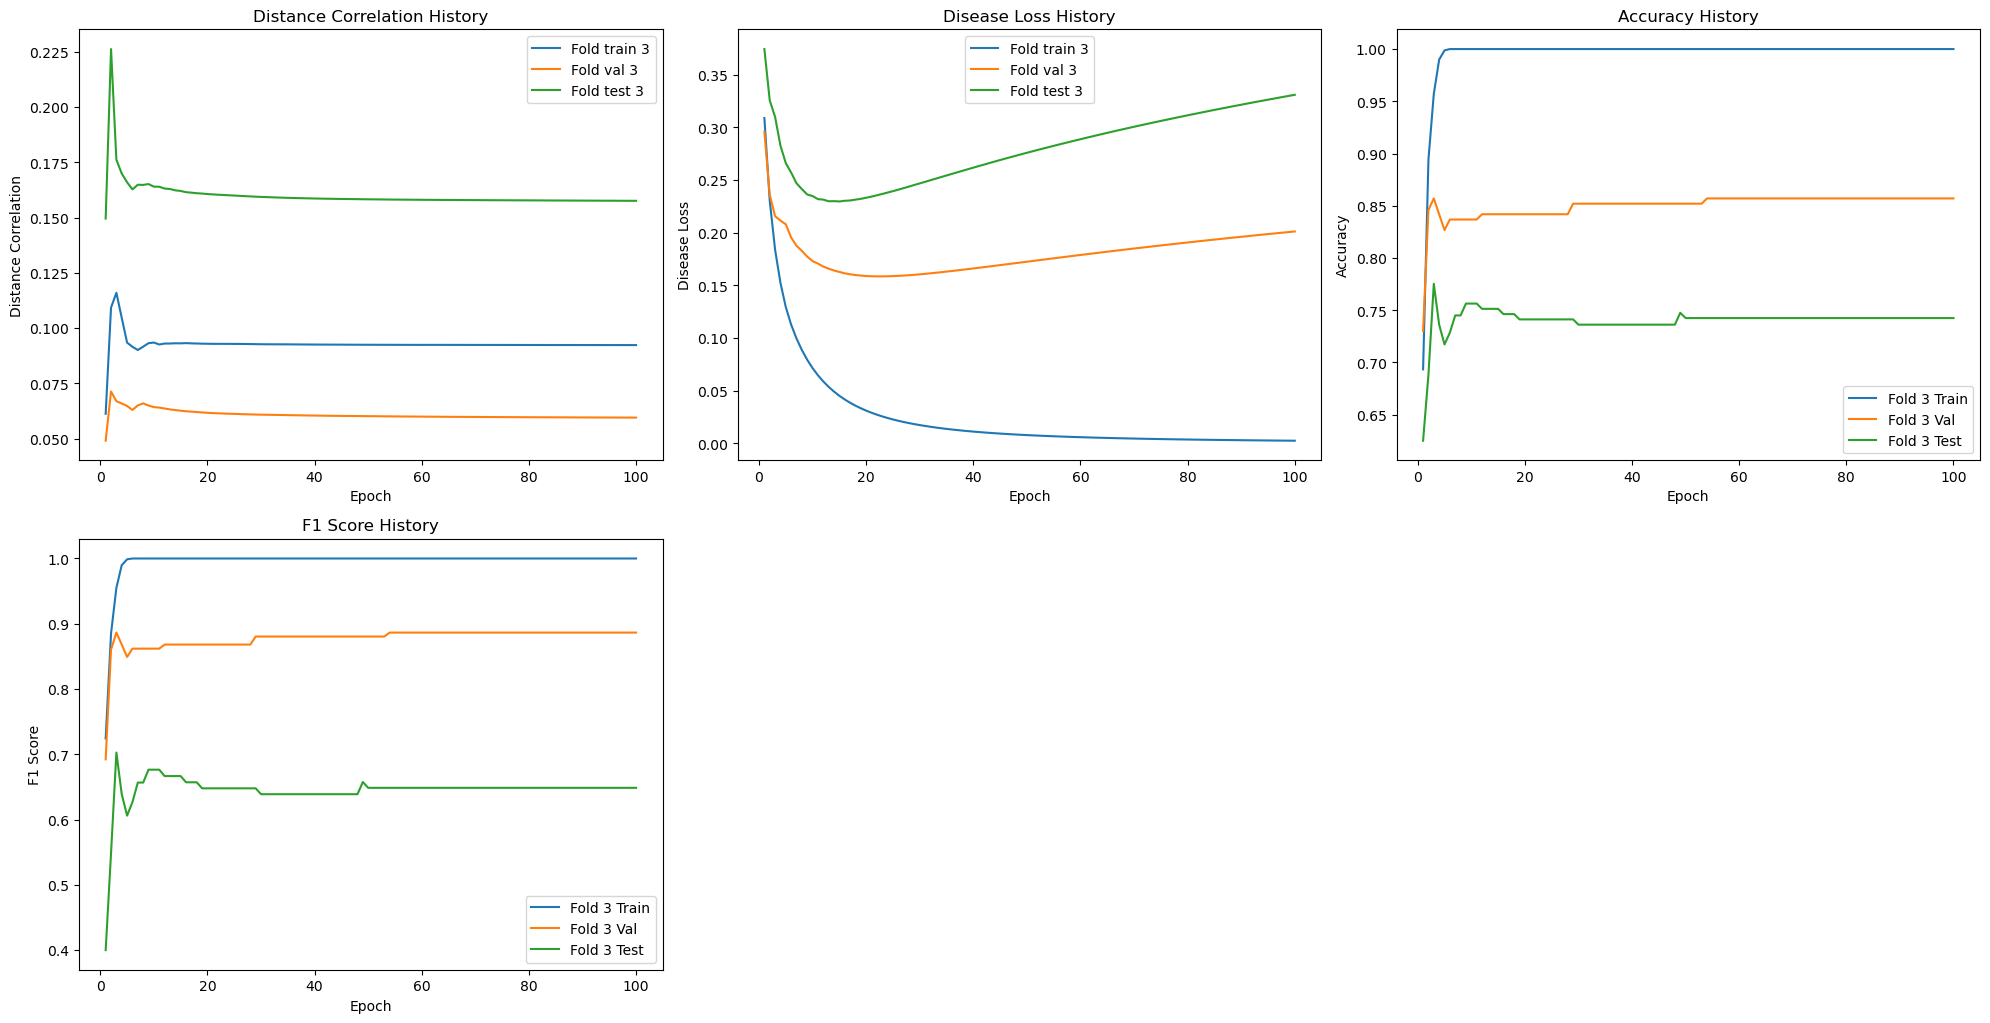

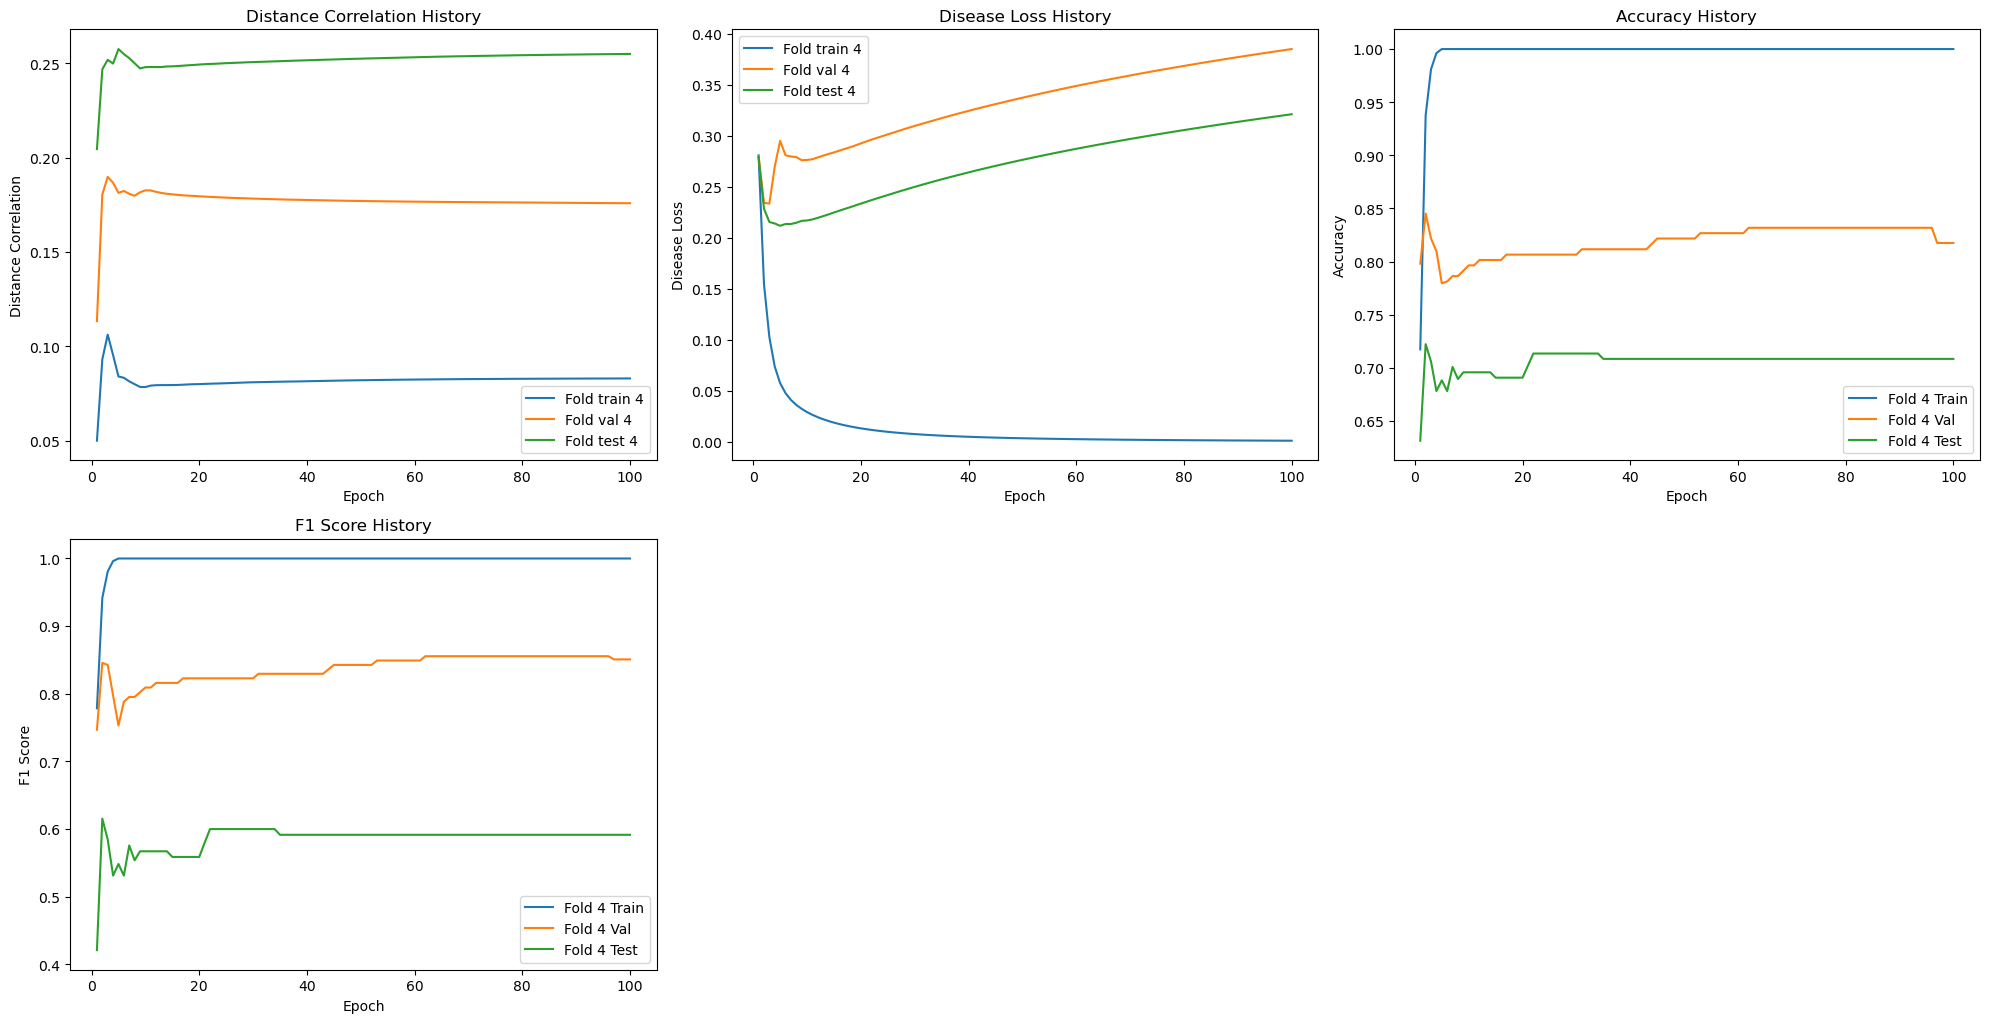

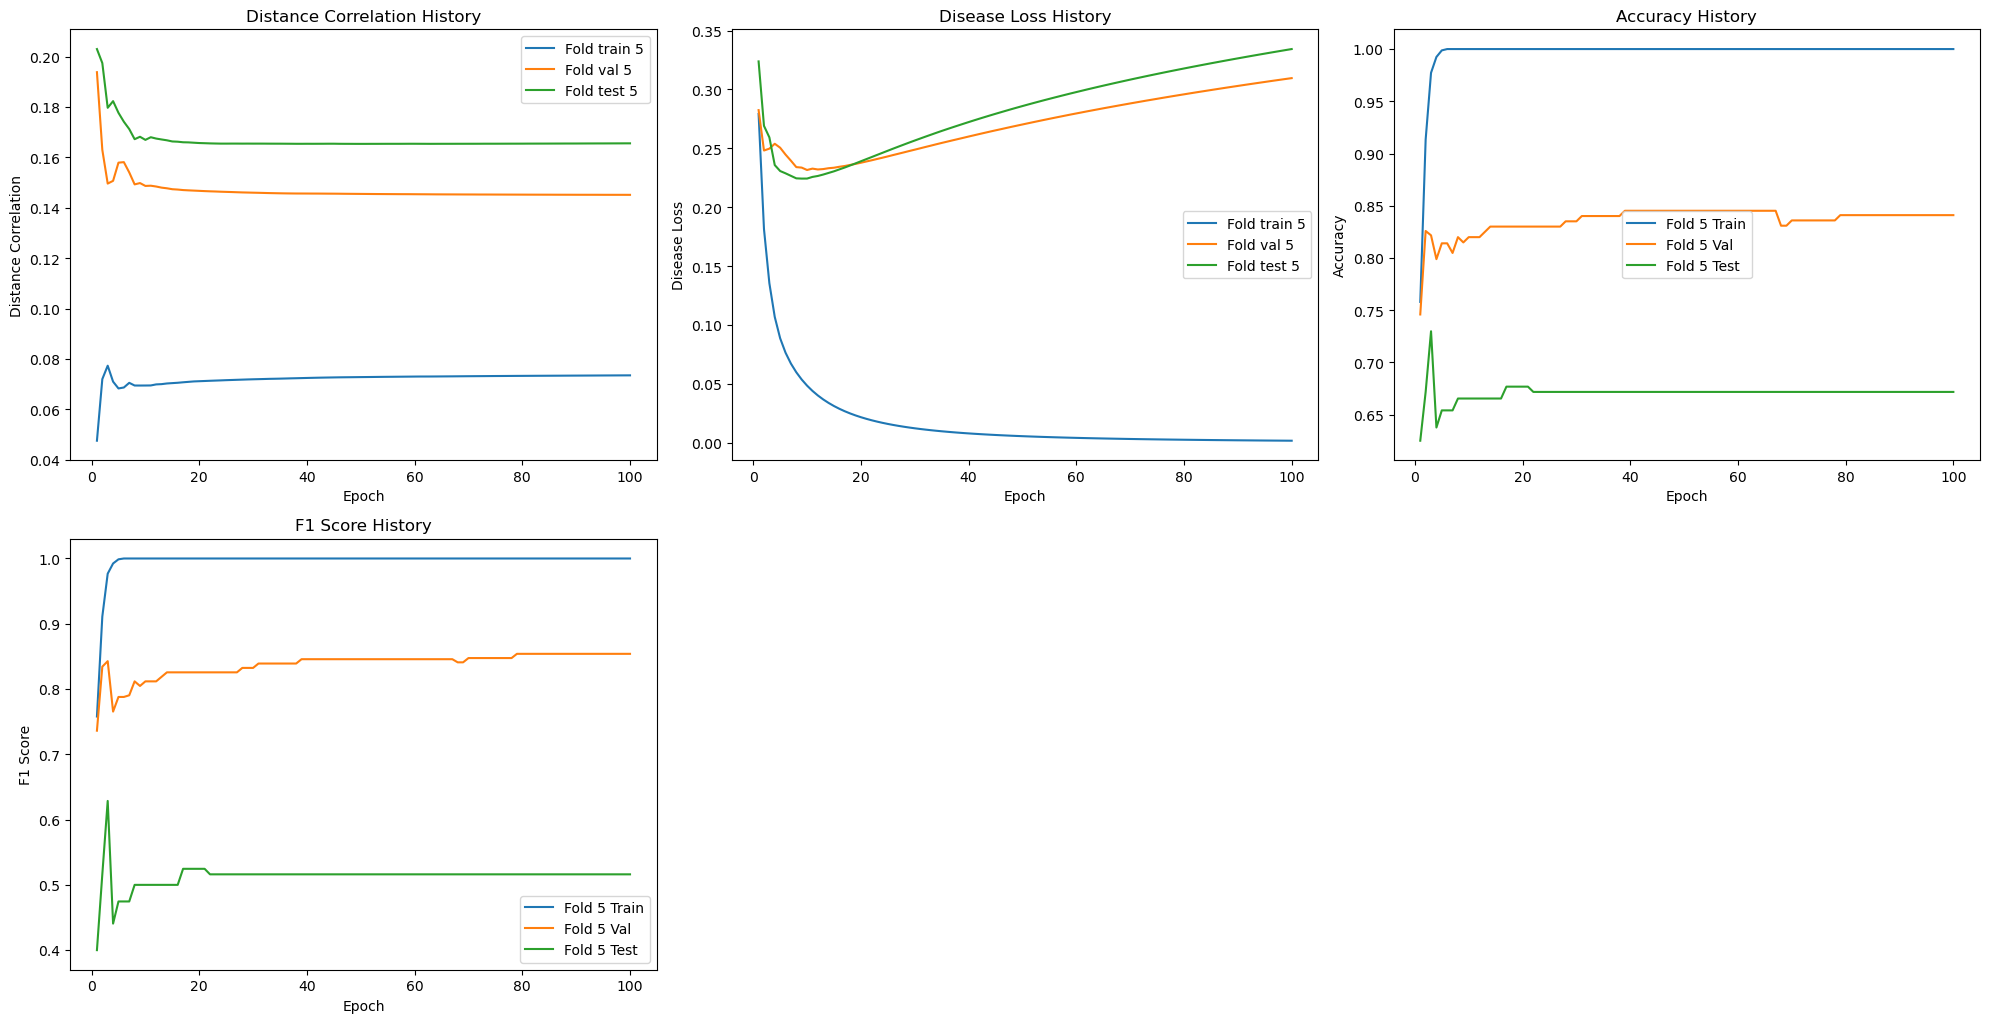

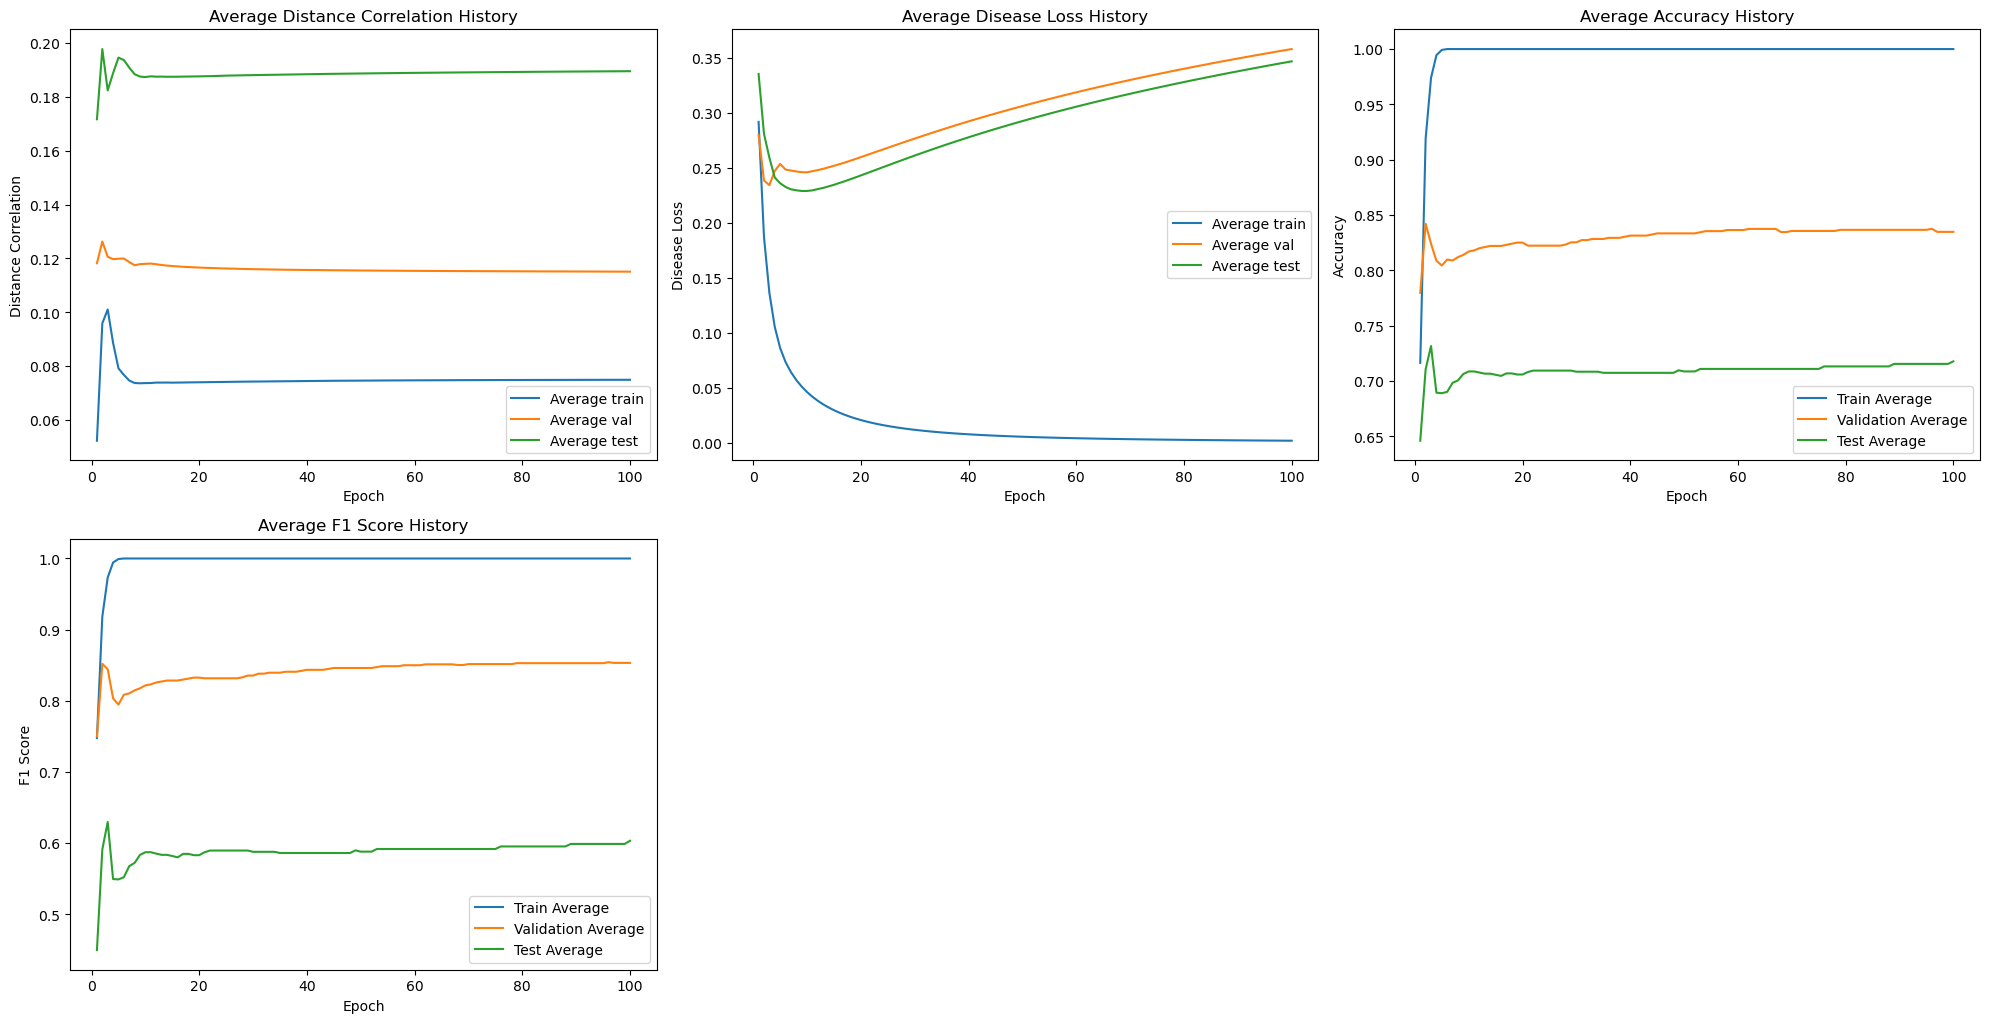

Average Test Accuracy over 5 folds: 0.7177


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def get_data():
    """
    Load and merge metadata and relative abundance data.
    """
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

def get_test_data():
    """
    Load and merge test metadata and relative abundance data.
    """
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, data_loader, data_all_loader, data_val_loader, data_all_val_loader, data_test_loader, data_all_test_loader, num_epochs, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    # New lists for validation metrics
    val_loss_history = []
    val_accs = []
    val_f1s = []
    val_dcor_history = []  # New list to store validation distance correlation
    # New lists for test metrics
    test_loss_history = []
    test_accs = []
    test_f1s = []
    test_dcor_history = []
    
    model = model.to(device)
   
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
             

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze classifier parameters
                
                encoded_features = model.encoder(x_batch)
               
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # ----------------------------
                # Train encoder & disease classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (torch.sigmoid(predicted_disease_all) > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute training metrics
       
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        # ----------------------------
        # Validation phase
        # ----------------------------
        model.eval()
        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_labels = []
        val_hidden_activations_list = []  # List to store validation hidden activations
        val_targets_list = []  # List to store validation targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_val_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease) > 0.5).float()
                epoch_val_preds.append(pred_tag.cpu())
                epoch_val_labels.append(y_batch.cpu())
                
            for x_batch, y_batch in data_val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                val_hidden_activations_list.append(encoded_features.cpu())
                val_targets_list.append(y_batch.cpu())

        avg_val_loss = epoch_val_loss / len(data_all_val_loader)
        val_loss_history.append(avg_val_loss)

        epoch_val_preds = torch.cat(epoch_val_preds)
        epoch_val_labels = torch.cat(epoch_val_labels)

        val_acc = balanced_accuracy_score(epoch_val_labels, epoch_val_preds)
        val_f1 = f1_score(epoch_val_labels, epoch_val_preds)

        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        # Compute distance correlation for validation data
        val_hidden_activations_all = torch.cat(val_hidden_activations_list, dim=0)
        val_targets_all = torch.cat(val_targets_list, dim=0)
        val_hidden_activations_np = val_hidden_activations_all.numpy()
        val_targets_np = val_targets_all.numpy()
        val_dcor_value = dcor.distance_correlation_sqr(val_hidden_activations_np, val_targets_np)
        val_dcor_history.append(val_dcor_value)
        
        # ----------------------------
        # Test phase
        # ----------------------------
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []
        test_hidden_activations_list = []  # List to store test hidden activations
        test_targets_list = []  # List to store test targets

        with torch.no_grad():
            for x_batch, y_batch in data_all_test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                predicted_disease = model.disease_classifier(encoded_features)
                c_loss = criterion_disease_classifier(predicted_disease, y_batch)
                epoch_test_loss += c_loss.item()
                pred_tag = (torch.sigmoid(predicted_disease) > 0.5).float()
                epoch_test_preds.append(pred_tag.cpu())
                epoch_test_labels.append(y_batch.cpu())
                
            for x_batch, y_batch in data_test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                encoded_features = model.encoder(x_batch)
                test_hidden_activations_list.append(encoded_features.cpu())
                test_targets_list.append(y_batch.cpu())

        avg_test_loss = epoch_test_loss / len(data_all_test_loader)
        test_loss_history.append(avg_test_loss)

        epoch_test_preds = torch.cat(epoch_test_preds)
        epoch_test_labels = torch.cat(epoch_test_labels)

        test_acc = balanced_accuracy_score(epoch_test_labels, epoch_test_preds)
        test_f1 = f1_score(epoch_test_labels, epoch_test_preds)

        test_accs.append(test_acc)
        test_f1s.append(test_f1)
        
        # Compute distance correlation for test data
        test_hidden_activations_all = torch.cat(test_hidden_activations_list, dim=0)
        test_targets_all = torch.cat(test_targets_list, dim=0)
        test_hidden_activations_np = test_hidden_activations_all.numpy()
        test_targets_np = test_targets_all.numpy()
        test_dcor_value = dcor.distance_correlation_sqr(test_hidden_activations_np, test_targets_np)
        test_dcor_history.append(test_dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], DCor: {dcor_value:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}, Val DCor: {val_dcor_value:.4f}')
            print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test DCor: {test_dcor_value:.4f}')
    
    return (dcor_history, disease_loss_history, train_disease_accs, 
            train_disease_f1s, val_loss_history, val_accs, val_f1s, val_dcor_history,
            test_loss_history, test_accs, test_f1s, test_dcor_history)

# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 64

    # Load merged data
    merged_data_all = get_data()
    merged_test_data_all = get_test_data()

    # Define feature columns
    metadata_columns = pd.read_csv('MetaCardis_data/train_T2D_metadata.csv').columns.tolist()
    feature_columns = [
        col for col in merged_data_all.columns if col not in metadata_columns and col != 'SampleID'
    ]

    X = merged_data_all[feature_columns].values
    y_all = merged_data_all['PATGROUPFINAL_C'].values  # Labels for disease classification

    # Prepare test data
    x_test_all = torch.tensor(merged_test_data_all[feature_columns].values, dtype=torch.float32)
    y_test_all = torch.tensor(merged_test_data_all['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
    
    # Disease group data (patients with PATGROUPFINAL_C == 1) in test set
    test_data_disease = merged_test_data_all[merged_test_data_all['PATGROUPFINAL_C'] == 1]
    x_test_disease = torch.tensor(test_data_disease[feature_columns].values, dtype=torch.float32)
    y_test_disease = torch.tensor(test_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    # Initialize StratifiedKFold
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # To store metrics across folds
    metrics_per_fold = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y_all)):
        print(f"Fold {fold+1}")

        # Split data into training and validation sets
        train_data = merged_data_all.iloc[train_index]
        val_data = merged_data_all.iloc[val_index]

        # Prepare training data
        x_all_train = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
        y_all_train = torch.tensor(train_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
        
        x_all_val = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
        y_all_val = torch.tensor(val_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
        
        # Disease group data (patients with PATGROUPFINAL_C == 1)
        train_data_disease = train_data[train_data['PATGROUPFINAL_C'] == 1]
        val_data_disease = val_data[val_data['PATGROUPFINAL_C'] == 1]
        
        x_disease_train = torch.tensor(train_data_disease[feature_columns].values, dtype=torch.float32)
        y_disease_train = torch.tensor(train_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
        
        x_disease_val = torch.tensor(val_data_disease[feature_columns].values, dtype=torch.float32)
        y_disease_val = torch.tensor(val_data_disease['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
        
        # Create stratified DataLoaders
        data_loader = create_stratified_dataloader(x_disease_train, y_disease_train, batch_size)
        data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
        data_val_loader = create_stratified_dataloader(x_disease_val, y_disease_val, batch_size)
        data_all_val_loader = create_stratified_dataloader(x_all_val, y_all_val, batch_size)
        data_test_loader = create_stratified_dataloader(x_test_disease, y_test_disease, batch_size)
        data_all_test_loader = create_stratified_dataloader(x_test_all, y_test_all, batch_size)
        
        # Compute positive class weight for disease classification
        num_pos_disease = y_all_train.sum().item()
        num_neg_disease = len(y_all_train) - num_pos_disease
        pos_weight_value_disease = num_neg_disease / num_pos_disease
        pos_weight_disease = torch.tensor([pos_weight_value_disease], dtype=torch.float32).to(device)

        # Compute positive class weight for drug classification
        num_pos_drug = y_disease_train.sum().item()
        num_neg_drug = len(y_disease_train) - num_pos_drug
        pos_weight_value_drug = num_neg_drug / num_pos_drug
        pos_weight_drug = torch.tensor([pos_weight_value_drug], dtype=torch.float32).to(device)


        # Define model, loss, and optimizer
        model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
        criterion_disease_classifier = nn.BCEWithLogitsLoss(pos_weight=pos_weight_disease).to(device)
        optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

        # Move model and criteria to device
        model = model.to(device)
        criterion_disease_classifier = criterion_disease_classifier.to(device)

        # Train the model
        (dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, 
         val_loss_history, val_accs, val_f1s, val_dcor_history,
         test_loss_history, test_accs, test_f1s, test_dcor_history) = train_model(
            model, data_loader, data_all_loader, data_val_loader, data_all_val_loader, data_test_loader, data_all_test_loader, num_epochs, 
            criterion_disease_classifier, optimizer_disease_classifier
        )

        # Store metrics for this fold
        metrics_per_fold.append({
            'dcor_history': dcor_history,
            'disease_loss_history': disease_loss_history,
            'train_disease_accs': train_disease_accs,
            'train_disease_f1s': train_disease_f1s,
            'val_loss_history': val_loss_history,
            'val_accs': val_accs,
            'val_f1s': val_f1s,
            'val_dcor_history': val_dcor_history,
            'test_loss_history': test_loss_history,
            'test_accs': test_accs,
            'test_f1s': test_f1s,
            'test_dcor_history': test_dcor_history
        })

    num_epochs = len(metrics_per_fold[0]['dcor_history'])
    epochs = range(1, num_epochs + 1)

    # Initialize dictionaries to collect metrics across folds
    avg_metrics = {
        'dcor_history': np.zeros(num_epochs),
        'disease_loss_history': np.zeros(num_epochs),
        'train_disease_accs': np.zeros(num_epochs),
        'train_disease_f1s': np.zeros(num_epochs),
        'val_loss_history': np.zeros(num_epochs),
        'val_accs': np.zeros(num_epochs),
        'val_f1s': np.zeros(num_epochs),
        'val_dcor_history': np.zeros(num_epochs),
        'test_loss_history': np.zeros(num_epochs),
        'test_accs': np.zeros(num_epochs),
        'test_f1s': np.zeros(num_epochs),
        'test_dcor_history': np.zeros(num_epochs)
    }

    # Plot metrics per fold and accumulate for averaging
    for fold_idx, fold_metrics in enumerate(metrics_per_fold):
        # Accumulate metrics for averaging
        for key in avg_metrics.keys():
            avg_metrics[key] += np.array(fold_metrics[key])
        
        # Plot metrics for this fold
        plt.figure(figsize=(20, 15))
        
        
        plt.subplot(3, 3, 1)
        plt.plot(epochs, fold_metrics['dcor_history'], label=f'Fold train {fold_idx+1}')
        plt.plot(epochs, fold_metrics['val_dcor_history'], label=f'Fold val {fold_idx+1}')
        plt.plot(epochs, fold_metrics['test_dcor_history'], label=f'Fold test {fold_idx+1}')
        plt.title("Distance Correlation History")
        plt.xlabel("Epoch")
        plt.ylabel("Distance Correlation")
        plt.legend()
        
        plt.subplot(3, 3, 2)
        plt.plot(epochs, fold_metrics['disease_loss_history'], label=f'Fold train {fold_idx+1}')
        plt.plot(epochs, fold_metrics['val_loss_history'], label=f'Fold val {fold_idx+1}')
        plt.plot(epochs, fold_metrics['test_loss_history'], label=f'Fold test {fold_idx+1}')
        plt.title("Disease Loss History")
        plt.xlabel("Epoch")
        plt.ylabel("Disease Loss")
        plt.legend()
        
        plt.subplot(3, 3, 3)
        plt.plot(epochs, fold_metrics['train_disease_accs'], label=f'Fold {fold_idx+1} Train')
        plt.plot(epochs, fold_metrics['val_accs'], label=f'Fold {fold_idx+1} Val')
        plt.plot(epochs, fold_metrics['test_accs'], label=f'Fold {fold_idx+1} Test')
        plt.title("Accuracy History")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.subplot(3, 3, 4)
        plt.plot(epochs, fold_metrics['train_disease_f1s'], label=f'Fold {fold_idx+1} Train')
        plt.plot(epochs, fold_metrics['val_f1s'], label=f'Fold {fold_idx+1} Val')
        plt.plot(epochs, fold_metrics['test_f1s'], label=f'Fold {fold_idx+1} Test')
        plt.title("F1 Score History")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    # Compute averages across folds
    for key in avg_metrics.keys():
        avg_metrics[key] /= len(metrics_per_fold)

    # Plot average metrics across folds
    plt.figure(figsize=(20, 15))

    

    plt.subplot(3, 3, 1)
    plt.plot(epochs, avg_metrics['dcor_history'], label='Average train')
    plt.plot(epochs, avg_metrics['val_dcor_history'], label='Average val')
    plt.plot(epochs, avg_metrics['test_dcor_history'], label='Average test')
    plt.title("Average Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")
    plt.legend()

    plt.subplot(3, 3, 2)
    plt.plot(epochs, avg_metrics['disease_loss_history'], label='Average train')
    plt.plot(epochs, avg_metrics['val_loss_history'], label='Average val')
    plt.plot(epochs, avg_metrics['test_loss_history'], label='Average test')
    plt.title("Average Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")
    plt.legend()

    plt.subplot(3, 3, 3)
    plt.plot(epochs, avg_metrics['train_disease_accs'], label='Train Average')
    plt.plot(epochs, avg_metrics['val_accs'], label='Validation Average')
    plt.plot(epochs, avg_metrics['test_accs'], label='Test Average')
    plt.title("Average Accuracy History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 3, 4)
    plt.plot(epochs, avg_metrics['train_disease_f1s'], label='Train Average')
    plt.plot(epochs, avg_metrics['val_f1s'], label='Validation Average')
    plt.plot(epochs, avg_metrics['test_f1s'], label='Test Average')
    plt.title("Average F1 Score History")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print average of the final epoch's test accuracy across folds
    avg_test_accs = avg_metrics['test_accs'][-1]
    print(f"Average Test Accuracy over {n_splits} folds: {avg_test_accs:.4f}")
